# TabNet

In [1]:
import os
from datetime import datetime
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchsummary as summary
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import optuna
import mlflow
import mlflow.pytorch

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import preprocess_for_all_models as my_preprocess
import word2vec_for_categorical_col as my_word2vec
import preprocess_for_nn as my_nn_preprocess
import cross_val as my_cross_validation

## 各種定数

In [3]:
RANDOM_STATE = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_EPOCHS = 100
LEARNING_RATE = 0.001
TARGET_COLUMN = "ProdTaken"
DROP_COLUMNS = ["id", "MonthlyIncome", "customer_info"]

In [4]:
# 今日の日付を取得し、YYYYMMDD形式にフォーマットする
today_str: str = datetime.now().strftime("%Y%m%d")

# 今日の日付をディレクトリ名として設定
data_directory_name: str = "../data/" + today_str
model_directory_name: str = "../models/" + today_str

# ディレクトリが存在しない場合、作成する
if not os.path.exists(data_directory_name):
    os.makedirs(data_directory_name)
if not os.path.exists(model_directory_name):
    os.makedirs(model_directory_name)


## 前処理

In [5]:
# ローカルファイルを読み込む
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
# google colaboratory で実行する場合は以下を有効にする
# from google.colab import drive
# drive.mount('/content/drive')
# train_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/train.csv")
# test_df = pd.read_csv("/content/drive/mydrive/signate_cup_2024_data/test.csv")

In [6]:
train_df["ProductPitched"].unique()

array(['Basic', 'Standard', 'Super Deluxe', 'basic', 'SUPER DELUXE',
       'super deluxe', 'BASIC', 'Deluxe', 'deluxe', 'STANᗞARD',
       'STANDARD', 'Вasic', 'DELUXE', 'ꓢuper De|uxe', 'Ѕuper Deluxe',
       'BAՏIC', 'Basıc', 'King', 'Super De|uxe', 'king', 'standard',
       'KING', 'BΑSIC', 'B𝖺sic', 'De|uxe', 'ᎠELUXE', 'Basiϲ', 'de|u×e',
       'Delu×e', 'Standar𝔡', 'Basi𝘤', 'Βasic', 'Տuper Deluxe', 'Staոdard',
       'BAꓢIC', 'ᗞeluxe', 'Տtandard', 'Βası𝘤', 'Kıng', 'Baｓic', 'basıc',
       'super de|uxe', 'Stand𝖺rd', 'S𝘵andard', '𐊡asic', 'St𝖺ndard',
       'Super ᗞeluxe', 'de|uxe', 'ｓuper deluxe', 'STANDARᎠ', 'Basiс',
       'DΕLUXΕ', 'ꓢuper Deluxe', 'BASΙC', 'ꓢtandard', 'В𝖺sic', 'Standa𝘳d',
       'basiϲ', 'staոdard', 'Super Ꭰeluxe', 'DELUXΕ', 'Ѕtandard', '𐊡asi𝘤',
       'Ꭰeluxe', 'Kıոg', '𝙳eluxe', 'Kiոg', 'Βasıc', 'BASIС',
       'SUPER DΕLUXE', 'B𝖺si𝘤', 'ΒASIС', 'Super 𝙳eluxe', 'Տtanda𝘳d',
       'Basıϲ', 'ЅTANDARD'], dtype=object)

In [7]:
# すべてのモデルに共通する前処理を実施
train_df, test_df = my_preprocess.preprocess_total(train_df, test_df)

In [8]:
train_df.to_csv(data_directory_name + "/train_preprocessed.csv", index=False)
test_df.to_csv(data_directory_name + "/test_preprocessed.csv", index=False)

In [9]:
train_df, test_df = my_nn_preprocess.preprocess_data(train_df, test_df)

"['customer_info_concat'] not found in axis"


## 学習用データの設定

In [10]:
X_train = train_df.drop(columns=[TARGET_COLUMN, "id"]).values  # 入力データ
y_train = train_df[TARGET_COLUMN].values  # ターゲット変数

In [11]:
# 検証用データの作成
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

In [12]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2791, 23), (698, 23), (2791,), (698,))

In [13]:
type(X_train)

numpy.ndarray

## 事前学習

In [14]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=optim.AdamW,
    optimizer_params=dict(lr=LEARNING_RATE),
    device_name=DEVICE,
    mask_type="entmax",
)
unsupervised_model.fit(
    X_train,
    eval_set=[X_val],
    batch_size=BATCH_SIZE,
    pretraining_ratio=0.8,
)

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 52.06425| val_0_unsup_loss_numpy: 5.781239986419678|  0:00:00s
epoch 1  | loss: 30.58602| val_0_unsup_loss_numpy: 7.119679927825928|  0:00:01s
epoch 2  | loss: 23.08941| val_0_unsup_loss_numpy: 7.850870132446289|  0:00:02s
epoch 3  | loss: 15.30139| val_0_unsup_loss_numpy: 8.946940422058105|  0:00:02s
epoch 4  | loss: 11.76938| val_0_unsup_loss_numpy: 12.858220100402832|  0:00:03s
epoch 5  | loss: 8.57924 | val_0_unsup_loss_numpy: 13.737380027770996|  0:00:04s
epoch 6  | loss: 6.62812 | val_0_unsup_loss_numpy: 9.020440101623535|  0:00:05s
epoch 7  | loss: 4.99901 | val_0_unsup_loss_numpy: 9.508600234985352|  0:00:06s
epoch 8  | loss: 3.79563 | val_0_unsup_loss_numpy: 8.731789588928223|  0:00:06s
epoch 9  | loss: 2.86262 | val_0_unsup_loss_numpy: 7.101150035858154|  0:00:07s
epoch 10 | loss: 2.19042 | val_0_unsup_loss_numpy: 4.922110080718994|  0:00:08s
epoch 11 | loss: 1.74458 | val_0_unsup_loss_numpy: 3.9398300647735596|  0:00:09s
epoch 12 | loss: 1.48899 | val_0_unsu

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [15]:
print(unsupervised_model)

TabNetPretrainer(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adamw.AdamW'>, optimizer_params={'lr': 0.001}, scheduler_fn=None, scheduler_params={}, mask_type='entmax', input_dim=23, output_dim=None, device_name=device(type='cpu'), n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


In [16]:
best_model = None

# Optunaの目的関数
def objective(trial):
    global best_model
    # ハイパーパラメータのサンプリング
    n_d = trial.suggest_int("n_d", 8, 64)
    n_a = trial.suggest_int("n_a", 8, 64)
    n_steps = trial.suggest_int("n_steps", 3, 10)
    gamma = trial.suggest_float("gamma", 1.0, 2.0)
    lambda_sparse = trial.suggest_float("lambda_sparse", 0.0, 1e-3)
    momentum = trial.suggest_float("momentum", 0.01, 0.4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
    clip_value = trial.suggest_float("clip_value", 1.0, 2.0)
    
    # TabNetモデルの定義
    model = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=learning_rate),
        clip_value=clip_value,
        momentum=momentum
    )

    # モデルの学習
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_name=["valid"],
        eval_metric=["auc"],
        max_epochs=NUM_EPOCHS,
        patience=10,
        batch_size=BATCH_SIZE,
        virtual_batch_size=16,
        num_workers=0,
        drop_last=False
    )
    
    # 検証データでの予測（確率）
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # ROC AUCスコアの計算
    auc = roc_auc_score(y_val, y_pred_proba)
    
    # ベストモデルを保存
    if best_model is None or auc > study.best_value:
        best_model = model
    
    return auc

# Optunaのスタディを作成して最適化を実行
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータの表示
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# ベストモデルの保存
if best_model is not None:
    joblib.dump(best_model, model_directory_name + "best_tabnet_model.pkl")
    print("Best model saved as 'best_tabnet_model.pkl'")

[I 2024-08-17 17:46:10,290] A new study created in memory with name: no-name-07ae305f-93d1-425f-a1c3-cddc1b2d22ea
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80579 | valid_auc: 0.42835 |  0:00:02s
epoch 1  | loss: 0.8398  | valid_auc: 0.42917 |  0:00:04s
epoch 2  | loss: 0.79835 | valid_auc: 0.48457 |  0:00:06s
epoch 3  | loss: 0.82146 | valid_auc: 0.46366 |  0:00:08s
epoch 4  | loss: 0.82043 | valid_auc: 0.47742 |  0:00:11s
epoch 5  | loss: 0.79363 | valid_auc: 0.44034 |  0:00:13s
epoch 6  | loss: 0.80013 | valid_auc: 0.48411 |  0:00:15s
epoch 7  | loss: 0.83563 | valid_auc: 0.48973 |  0:00:18s
epoch 8  | loss: 0.83864 | valid_auc: 0.48297 |  0:00:20s
epoch 9  | loss: 0.80575 | valid_auc: 0.46567 |  0:00:22s
epoch 10 | loss: 0.83907 | valid_auc: 0.55709 |  0:00:24s
epoch 11 | loss: 0.81456 | valid_auc: 0.52365 |  0:00:27s
epoch 12 | loss: 0.82161 | valid_auc: 0.49802 |  0:00:29s
epoch 13 | loss: 0.80855 | valid_auc: 0.50215 |  0:00:31s
epoch 14 | loss: 0.77986 | valid_auc: 0.47656 |  0:00:33s
epoch 15 | loss: 0.79225 | valid_auc: 0.50072 |  0:00:35s
epoch 16 | loss: 0.82403 | valid_auc: 0.50511 |  0:00:36s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:46:55,866] Trial 0 finished with value: 0.5570903561018883 and parameters: {'n_d': 21, 'n_a': 13, 'n_steps': 8, 'gamma': 1.5935800761849195, 'lambda_sparse': 0.0008831289363954862, 'momentum': 0.11617465537821729, 'learning_rate': 1.8696299816311343e-05, 'clip_value': 1.9083045863885115}. Best is trial 0 with value: 0.5570903561018883.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 1.61944 | valid_auc: 0.66017 |  0:00:03s
epoch 1  | loss: 0.75372 | valid_auc: 0.55724 |  0:00:06s
epoch 2  | loss: 0.41876 | valid_auc: 0.65952 |  0:00:09s
epoch 3  | loss: 0.49726 | valid_auc: 0.75725 |  0:00:12s
epoch 4  | loss: 0.37874 | valid_auc: 0.68778 |  0:00:15s
epoch 5  | loss: 0.37995 | valid_auc: 0.74738 |  0:00:18s
epoch 6  | loss: 0.37916 | valid_auc: 0.69582 |  0:00:21s
epoch 7  | loss: 0.38186 | valid_auc: 0.72903 |  0:00:24s
epoch 8  | loss: 0.37648 | valid_auc: 0.74401 |  0:00:27s
epoch 9  | loss: 0.38868 | valid_auc: 0.78149 |  0:00:30s
epoch 10 | loss: 0.36783 | valid_auc: 0.78164 |  0:00:33s
epoch 11 | loss: 0.35955 | valid_auc: 0.77361 |  0:00:36s
epoch 12 | loss: 0.35205 | valid_auc: 0.79383 |  0:00:39s
epoch 13 | loss: 0.36362 | valid_auc: 0.81373 |  0:00:43s
epoch 14 | loss: 0.35758 | valid_auc: 0.80197 |  0:00:46s
epoch 15 | loss: 0.35356 | valid_auc: 0.80588 |  0:00:49s
epoch 16 | loss: 0.35987 | valid_auc: 0.7313  |  0:00:52s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:49:00,993] Trial 1 finished with value: 0.8400347593098829 and parameters: {'n_d': 59, 'n_a': 59, 'n_steps': 10, 'gamma': 1.9702326888518833, 'lambda_sparse': 0.0001847404433859845, 'momentum': 0.23670901502616956, 'learning_rate': 0.024322416518577413, 'clip_value': 1.988851875681271}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 1.51233 | valid_auc: 0.45975 |  0:00:01s
epoch 1  | loss: 1.24791 | valid_auc: 0.4657  |  0:00:02s
epoch 2  | loss: 1.14371 | valid_auc: 0.51728 |  0:00:04s
epoch 3  | loss: 0.98811 | valid_auc: 0.55294 |  0:00:05s
epoch 4  | loss: 0.84395 | valid_auc: 0.61426 |  0:00:07s
epoch 5  | loss: 0.80384 | valid_auc: 0.61814 |  0:00:09s
epoch 6  | loss: 0.71768 | valid_auc: 0.58003 |  0:00:10s
epoch 7  | loss: 0.71893 | valid_auc: 0.58311 |  0:00:12s
epoch 8  | loss: 0.68138 | valid_auc: 0.59245 |  0:00:13s
epoch 9  | loss: 0.6567  | valid_auc: 0.52995 |  0:00:15s
epoch 10 | loss: 0.64339 | valid_auc: 0.55322 |  0:00:16s
epoch 11 | loss: 0.65656 | valid_auc: 0.47818 |  0:00:18s
epoch 12 | loss: 0.63804 | valid_auc: 0.54641 |  0:00:19s
epoch 13 | loss: 0.63831 | valid_auc: 0.53468 |  0:00:21s
epoch 14 | loss: 0.61465 | valid_auc: 0.54279 |  0:00:22s
epoch 15 | loss: 0.60577 | valid_auc: 0.54065 |  0:00:24s

Early stopping occurred at epoch 15 with best_epoch = 5 and best_valid_

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:49:26,119] Trial 2 finished with value: 0.6181363940836757 and parameters: {'n_d': 47, 'n_a': 40, 'n_steps': 5, 'gamma': 1.2274554038844814, 'lambda_sparse': 0.0008797289135098185, 'momentum': 0.13907068250006735, 'learning_rate': 7.802754362216595e-05, 'clip_value': 1.567921311957503}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.89959 | valid_auc: 0.58586 |  0:00:02s
epoch 1  | loss: 0.62336 | valid_auc: 0.61272 |  0:00:04s
epoch 2  | loss: 0.55933 | valid_auc: 0.57481 |  0:00:06s
epoch 3  | loss: 0.52758 | valid_auc: 0.6538  |  0:00:08s
epoch 4  | loss: 0.48933 | valid_auc: 0.66025 |  0:00:10s
epoch 5  | loss: 0.47604 | valid_auc: 0.61265 |  0:00:12s
epoch 6  | loss: 0.46937 | valid_auc: 0.69935 |  0:00:15s
epoch 7  | loss: 0.45298 | valid_auc: 0.66432 |  0:00:17s
epoch 8  | loss: 0.45252 | valid_auc: 0.74618 |  0:00:19s
epoch 9  | loss: 0.43519 | valid_auc: 0.70883 |  0:00:21s
epoch 10 | loss: 0.41733 | valid_auc: 0.67437 |  0:00:23s
epoch 11 | loss: 0.4248  | valid_auc: 0.73185 |  0:00:26s
epoch 12 | loss: 0.42614 | valid_auc: 0.73123 |  0:00:28s
epoch 13 | loss: 0.4242  | valid_auc: 0.73478 |  0:00:30s
epoch 14 | loss: 0.41065 | valid_auc: 0.77566 |  0:00:32s
epoch 15 | loss: 0.42199 | valid_auc: 0.74074 |  0:00:34s
epoch 16 | loss: 0.40901 | valid_auc: 0.74955 |  0:00:36s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:51:03,584] Trial 3 finished with value: 0.8059271864873183 and parameters: {'n_d': 48, 'n_a': 38, 'n_steps': 7, 'gamma': 1.41529244619859, 'lambda_sparse': 0.0007086272923078736, 'momentum': 0.29027311644961035, 'learning_rate': 0.0012572358050318222, 'clip_value': 1.103358323417579}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyt

epoch 0  | loss: 1.64585 | valid_auc: 0.66149 |  0:00:02s
epoch 1  | loss: 0.44297 | valid_auc: 0.73451 |  0:00:05s
epoch 2  | loss: 0.40308 | valid_auc: 0.78751 |  0:00:08s
epoch 3  | loss: 0.39273 | valid_auc: 0.78676 |  0:00:11s
epoch 4  | loss: 0.3841  | valid_auc: 0.80905 |  0:00:14s
epoch 5  | loss: 0.36856 | valid_auc: 0.81445 |  0:00:17s
epoch 6  | loss: 0.36976 | valid_auc: 0.78685 |  0:00:20s
epoch 7  | loss: 0.38582 | valid_auc: 0.79456 |  0:00:23s
epoch 8  | loss: 0.38508 | valid_auc: 0.75878 |  0:00:26s
epoch 9  | loss: 0.3735  | valid_auc: 0.78173 |  0:00:29s
epoch 10 | loss: 0.36965 | valid_auc: 0.81442 |  0:00:32s
epoch 11 | loss: 0.37411 | valid_auc: 0.81055 |  0:00:35s
epoch 12 | loss: 0.36155 | valid_auc: 0.81488 |  0:00:38s
epoch 13 | loss: 0.36003 | valid_auc: 0.82011 |  0:00:41s
epoch 14 | loss: 0.36032 | valid_auc: 0.83118 |  0:00:44s
epoch 15 | loss: 0.36763 | valid_auc: 0.82202 |  0:00:47s
epoch 16 | loss: 0.36    | valid_auc: 0.82139 |  0:00:50s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:52:22,791] Trial 4 finished with value: 0.8311819975740898 and parameters: {'n_d': 59, 'n_a': 60, 'n_steps': 9, 'gamma': 1.8612337553956944, 'lambda_sparse': 3.4366717969681606e-06, 'momentum': 0.04209219629487546, 'learning_rate': 0.08248579571530303, 'clip_value': 1.796076315596723}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.20183 | valid_auc: 0.55383 |  0:00:02s
epoch 1  | loss: 1.18729 | valid_auc: 0.58039 |  0:00:04s
epoch 2  | loss: 1.14222 | valid_auc: 0.53631 |  0:00:06s
epoch 3  | loss: 1.09725 | valid_auc: 0.56008 |  0:00:09s
epoch 4  | loss: 1.06412 | valid_auc: 0.51006 |  0:00:11s
epoch 5  | loss: 1.12449 | valid_auc: 0.50497 |  0:00:13s
epoch 6  | loss: 1.07169 | valid_auc: 0.51654 |  0:00:15s
epoch 7  | loss: 1.05399 | valid_auc: 0.46898 |  0:00:18s
epoch 8  | loss: 1.04866 | valid_auc: 0.53006 |  0:00:20s
epoch 9  | loss: 1.01579 | valid_auc: 0.51744 |  0:00:22s
epoch 10 | loss: 1.00988 | valid_auc: 0.53558 |  0:00:24s
epoch 11 | loss: 0.99868 | valid_auc: 0.48993 |  0:00:25s

Early stopping occurred at epoch 11 with best_epoch = 1 and best_valid_auc = 0.58039


/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:52:49,308] Trial 5 finished with value: 0.5803899560077483 and parameters: {'n_d': 28, 'n_a': 42, 'n_steps': 7, 'gamma': 1.7629155820494833, 'lambda_sparse': 0.00018620145348368234, 'momentum': 0.0880222767514593, 'learning_rate': 4.0206980762947934e-05, 'clip_value': 1.048799600593005}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.8087  | valid_auc: 0.65768 |  0:00:01s
epoch 1  | loss: 0.70811 | valid_auc: 0.62777 |  0:00:03s
epoch 2  | loss: 0.66627 | valid_auc: 0.65474 |  0:00:06s
epoch 3  | loss: 0.62616 | valid_auc: 0.70771 |  0:00:08s
epoch 4  | loss: 0.5835  | valid_auc: 0.6769  |  0:00:10s
epoch 5  | loss: 0.54286 | valid_auc: 0.69354 |  0:00:12s
epoch 6  | loss: 0.53307 | valid_auc: 0.71177 |  0:00:15s
epoch 7  | loss: 0.50003 | valid_auc: 0.71883 |  0:00:17s
epoch 8  | loss: 0.47827 | valid_auc: 0.68423 |  0:00:19s
epoch 9  | loss: 0.47536 | valid_auc: 0.69341 |  0:00:21s
epoch 10 | loss: 0.45773 | valid_auc: 0.68928 |  0:00:23s
epoch 11 | loss: 0.45495 | valid_auc: 0.69846 |  0:00:25s
epoch 12 | loss: 0.44231 | valid_auc: 0.68887 |  0:00:27s
epoch 13 | loss: 0.45752 | valid_auc: 0.72792 |  0:00:29s
epoch 14 | loss: 0.44401 | valid_auc: 0.73869 |  0:00:31s
epoch 15 | loss: 0.44343 | valid_auc: 0.72017 |  0:00:33s
epoch 16 | loss: 0.43046 | valid_auc: 0.73628 |  0:00:35s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:53:47,852] Trial 6 finished with value: 0.763582381374803 and parameters: {'n_d': 34, 'n_a': 34, 'n_steps': 6, 'gamma': 1.42435782661721, 'lambda_sparse': 0.0006261234370432729, 'momentum': 0.018631101840587732, 'learning_rate': 0.0006834938280791207, 'clip_value': 1.0836125928066163}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.60778 | valid_auc: 0.6972  |  0:00:02s
epoch 1  | loss: 0.40327 | valid_auc: 0.64879 |  0:00:04s
epoch 2  | loss: 0.39466 | valid_auc: 0.70489 |  0:00:06s
epoch 3  | loss: 0.38538 | valid_auc: 0.71854 |  0:00:09s
epoch 4  | loss: 0.38664 | valid_auc: 0.76731 |  0:00:12s
epoch 5  | loss: 0.37452 | valid_auc: 0.74759 |  0:00:14s
epoch 6  | loss: 0.38909 | valid_auc: 0.6615  |  0:00:17s
epoch 7  | loss: 0.38687 | valid_auc: 0.72488 |  0:00:20s
epoch 8  | loss: 0.38534 | valid_auc: 0.76729 |  0:00:23s
epoch 9  | loss: 0.37987 | valid_auc: 0.79435 |  0:00:25s
epoch 10 | loss: 0.37334 | valid_auc: 0.77908 |  0:00:28s
epoch 11 | loss: 0.3796  | valid_auc: 0.79545 |  0:00:30s
epoch 12 | loss: 0.38074 | valid_auc: 0.75841 |  0:00:33s
epoch 13 | loss: 0.38781 | valid_auc: 0.77759 |  0:00:35s
epoch 14 | loss: 0.37633 | valid_auc: 0.77473 |  0:00:38s
epoch 15 | loss: 0.36733 | valid_auc: 0.79527 |  0:00:41s
epoch 16 | loss: 0.36485 | valid_auc: 0.81742 |  0:00:43s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:55:01,405] Trial 7 finished with value: 0.8174231040787878 and parameters: {'n_d': 20, 'n_a': 64, 'n_steps': 9, 'gamma': 1.7924756489083138, 'lambda_sparse': 0.00023517728036656383, 'momentum': 0.261106249259168, 'learning_rate': 0.09965325419102386, 'clip_value': 1.388278279920954}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pyto

epoch 0  | loss: 4.83707 | valid_auc: 0.519   |  0:00:02s
epoch 1  | loss: 4.78702 | valid_auc: 0.55533 |  0:00:05s
epoch 2  | loss: 4.62966 | valid_auc: 0.5854  |  0:00:08s
epoch 3  | loss: 4.50484 | valid_auc: 0.5553  |  0:00:11s
epoch 4  | loss: 4.43415 | valid_auc: 0.52425 |  0:00:14s
epoch 5  | loss: 4.28178 | valid_auc: 0.5236  |  0:00:18s
epoch 6  | loss: 4.19781 | valid_auc: 0.54824 |  0:00:21s
epoch 7  | loss: 4.16237 | valid_auc: 0.55061 |  0:00:24s
epoch 8  | loss: 4.06562 | valid_auc: 0.50075 |  0:00:28s
epoch 9  | loss: 3.92044 | valid_auc: 0.49668 |  0:00:31s
epoch 10 | loss: 3.86376 | valid_auc: 0.51933 |  0:00:34s
epoch 11 | loss: 3.6886  | valid_auc: 0.55448 |  0:00:37s
epoch 12 | loss: 3.64039 | valid_auc: 0.57845 |  0:00:40s

Early stopping occurred at epoch 12 with best_epoch = 2 and best_valid_auc = 0.5854


/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:55:42,833] Trial 8 finished with value: 0.5854047106106415 and parameters: {'n_d': 15, 'n_a': 49, 'n_steps': 10, 'gamma': 1.767898520732579, 'lambda_sparse': 0.0006065182967567968, 'momentum': 0.039913860634726316, 'learning_rate': 6.128309365479617e-05, 'clip_value': 1.2086906930782026}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.51271 | valid_auc: 0.5253  |  0:00:03s
epoch 1  | loss: 0.49371 | valid_auc: 0.61238 |  0:00:06s
epoch 2  | loss: 0.46289 | valid_auc: 0.62507 |  0:00:10s
epoch 3  | loss: 0.43369 | valid_auc: 0.65574 |  0:00:13s
epoch 4  | loss: 0.42402 | valid_auc: 0.671   |  0:00:17s
epoch 5  | loss: 0.41644 | valid_auc: 0.65114 |  0:00:20s
epoch 6  | loss: 0.40548 | valid_auc: 0.69877 |  0:00:23s
epoch 7  | loss: 0.40044 | valid_auc: 0.71633 |  0:00:26s
epoch 8  | loss: 0.38863 | valid_auc: 0.75317 |  0:00:30s
epoch 9  | loss: 0.39797 | valid_auc: 0.76414 |  0:00:33s
epoch 10 | loss: 0.39537 | valid_auc: 0.74494 |  0:00:36s
epoch 11 | loss: 0.38741 | valid_auc: 0.73415 |  0:00:38s
epoch 12 | loss: 0.38739 | valid_auc: 0.72118 |  0:00:41s
epoch 13 | loss: 0.38958 | valid_auc: 0.70391 |  0:00:44s
epoch 14 | loss: 0.39387 | valid_auc: 0.72386 |  0:00:46s
epoch 15 | loss: 0.38917 | valid_auc: 0.74561 |  0:00:49s
epoch 16 | loss: 0.38344 | valid_auc: 0.74564 |  0:00:51s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:56:44,405] Trial 9 finished with value: 0.7641435993989536 and parameters: {'n_d': 9, 'n_a': 62, 'n_steps': 10, 'gamma': 1.6947925416328502, 'lambda_sparse': 0.0009877462645083753, 'momentum': 0.23964922865311336, 'learning_rate': 0.002725348764350539, 'clip_value': 1.6017290119948349}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.69786 | valid_auc: 0.58407 |  0:00:01s
epoch 1  | loss: 0.48536 | valid_auc: 0.61508 |  0:00:02s
epoch 2  | loss: 0.42496 | valid_auc: 0.64441 |  0:00:04s
epoch 3  | loss: 0.39428 | valid_auc: 0.63842 |  0:00:05s
epoch 4  | loss: 0.40019 | valid_auc: 0.69646 |  0:00:07s
epoch 5  | loss: 0.38965 | valid_auc: 0.71022 |  0:00:08s
epoch 6  | loss: 0.38589 | valid_auc: 0.7226  |  0:00:09s
epoch 7  | loss: 0.38162 | valid_auc: 0.73365 |  0:00:11s
epoch 8  | loss: 0.38283 | valid_auc: 0.72512 |  0:00:12s
epoch 9  | loss: 0.37547 | valid_auc: 0.71942 |  0:00:14s
epoch 10 | loss: 0.37735 | valid_auc: 0.75374 |  0:00:15s
epoch 11 | loss: 0.37001 | valid_auc: 0.79199 |  0:00:16s
epoch 12 | loss: 0.36995 | valid_auc: 0.78963 |  0:00:18s
epoch 13 | loss: 0.36701 | valid_auc: 0.74483 |  0:00:19s
epoch 14 | loss: 0.38181 | valid_auc: 0.75372 |  0:00:21s
epoch 15 | loss: 0.37553 | valid_auc: 0.74623 |  0:00:22s
epoch 16 | loss: 0.37789 | valid_auc: 0.75695 |  0:00:23s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:57:16,526] Trial 10 finished with value: 0.7919872549197096 and parameters: {'n_d': 63, 'n_a': 22, 'n_steps': 4, 'gamma': 1.99360221102114, 'lambda_sparse': 0.00037901682807078184, 'momentum': 0.3892702577480829, 'learning_rate': 0.012247722179361922, 'clip_value': 1.9385083788545836}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.62318 | valid_auc: 0.58488 |  0:00:02s
epoch 1  | loss: 0.42893 | valid_auc: 0.75736 |  0:00:04s
epoch 2  | loss: 0.40277 | valid_auc: 0.77893 |  0:00:07s
epoch 3  | loss: 0.37779 | valid_auc: 0.80471 |  0:00:10s
epoch 4  | loss: 0.36388 | valid_auc: 0.78842 |  0:00:13s
epoch 5  | loss: 0.37509 | valid_auc: 0.80476 |  0:00:17s
epoch 6  | loss: 0.36235 | valid_auc: 0.80427 |  0:00:19s
epoch 7  | loss: 0.36363 | valid_auc: 0.80259 |  0:00:23s
epoch 8  | loss: 0.3582  | valid_auc: 0.81636 |  0:00:26s
epoch 9  | loss: 0.37525 | valid_auc: 0.80014 |  0:00:29s
epoch 10 | loss: 0.37013 | valid_auc: 0.79424 |  0:00:32s
epoch 11 | loss: 0.37032 | valid_auc: 0.8144  |  0:00:35s
epoch 12 | loss: 0.37204 | valid_auc: 0.80184 |  0:00:37s
epoch 13 | loss: 0.36796 | valid_auc: 0.7874  |  0:00:40s
epoch 14 | loss: 0.35358 | valid_auc: 0.80833 |  0:00:42s
epoch 15 | loss: 0.36583 | valid_auc: 0.80157 |  0:00:45s
epoch 16 | loss: 0.36881 | valid_auc: 0.81652 |  0:00:47s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 17:58:41,815] Trial 11 finished with value: 0.8285388417184134 and parameters: {'n_d': 63, 'n_a': 54, 'n_steps': 9, 'gamma': 1.9766948772800654, 'lambda_sparse': 4.508413498237085e-05, 'momentum': 0.18226263324203668, 'learning_rate': 0.07340101355477352, 'clip_value': 1.789626193638175}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.0608  | valid_auc: 0.4965  |  0:00:02s
epoch 1  | loss: 0.9529  | valid_auc: 0.60096 |  0:00:05s
epoch 2  | loss: 0.55493 | valid_auc: 0.6105  |  0:00:08s
epoch 3  | loss: 0.45323 | valid_auc: 0.69968 |  0:00:11s
epoch 4  | loss: 0.41531 | valid_auc: 0.75431 |  0:00:14s
epoch 5  | loss: 0.37832 | valid_auc: 0.75998 |  0:00:17s
epoch 6  | loss: 0.36568 | valid_auc: 0.77716 |  0:00:20s
epoch 7  | loss: 0.36945 | valid_auc: 0.72408 |  0:00:23s
epoch 8  | loss: 0.37005 | valid_auc: 0.78085 |  0:00:26s
epoch 9  | loss: 0.36741 | valid_auc: 0.77922 |  0:00:30s
epoch 10 | loss: 0.35516 | valid_auc: 0.77832 |  0:00:33s
epoch 11 | loss: 0.35727 | valid_auc: 0.78407 |  0:00:36s
epoch 12 | loss: 0.35289 | valid_auc: 0.80606 |  0:00:39s
epoch 13 | loss: 0.34962 | valid_auc: 0.81491 |  0:00:42s
epoch 14 | loss: 0.35202 | valid_auc: 0.82787 |  0:00:45s
epoch 15 | loss: 0.34785 | valid_auc: 0.81846 |  0:00:48s
epoch 16 | loss: 0.34835 | valid_auc: 0.81773 |  0:00:52s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:00:10,900] Trial 12 finished with value: 0.8356174303456017 and parameters: {'n_d': 51, 'n_a': 55, 'n_steps': 9, 'gamma': 1.8885711150054847, 'lambda_sparse': 6.8280422006013945e-06, 'momentum': 0.3319745016324698, 'learning_rate': 0.01360696409024926, 'clip_value': 1.7483266127846175}. Best is trial 1 with value: 0.8400347593098829.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.50343 | valid_auc: 0.59004 |  0:00:01s
epoch 1  | loss: 0.41523 | valid_auc: 0.75004 |  0:00:02s
epoch 2  | loss: 0.3802  | valid_auc: 0.79753 |  0:00:03s
epoch 3  | loss: 0.37414 | valid_auc: 0.77714 |  0:00:04s
epoch 4  | loss: 0.35688 | valid_auc: 0.818   |  0:00:05s
epoch 5  | loss: 0.36397 | valid_auc: 0.82887 |  0:00:06s
epoch 6  | loss: 0.35911 | valid_auc: 0.82424 |  0:00:07s
epoch 7  | loss: 0.36187 | valid_auc: 0.82174 |  0:00:08s
epoch 8  | loss: 0.33913 | valid_auc: 0.83376 |  0:00:09s
epoch 9  | loss: 0.34961 | valid_auc: 0.83352 |  0:00:09s
epoch 10 | loss: 0.34393 | valid_auc: 0.84369 |  0:00:11s
epoch 11 | loss: 0.3387  | valid_auc: 0.83562 |  0:00:12s
epoch 12 | loss: 0.34639 | valid_auc: 0.80355 |  0:00:14s
epoch 13 | loss: 0.34202 | valid_auc: 0.81819 |  0:00:15s
epoch 14 | loss: 0.34305 | valid_auc: 0.81947 |  0:00:16s
epoch 15 | loss: 0.34363 | valid_auc: 0.82676 |  0:00:17s
epoch 16 | loss: 0.34225 | valid_auc: 0.82875 |  0:00:18s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:00:34,837] Trial 13 finished with value: 0.8436917283704762 and parameters: {'n_d': 51, 'n_a': 51, 'n_steps': 3, 'gamma': 1.1912783407358838, 'lambda_sparse': 0.00022257431512154525, 'momentum': 0.35097152173905827, 'learning_rate': 0.013926623805539272, 'clip_value': 1.7529335662511438}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 0.6076  | valid_auc: 0.67763 |  0:00:00s
epoch 1  | loss: 0.41648 | valid_auc: 0.74367 |  0:00:01s
epoch 2  | loss: 0.38272 | valid_auc: 0.71434 |  0:00:03s
epoch 3  | loss: 0.36264 | valid_auc: 0.74096 |  0:00:04s
epoch 4  | loss: 0.36794 | valid_auc: 0.76358 |  0:00:05s
epoch 5  | loss: 0.3635  | valid_auc: 0.79554 |  0:00:06s
epoch 6  | loss: 0.35011 | valid_auc: 0.84165 |  0:00:07s
epoch 7  | loss: 0.34812 | valid_auc: 0.83262 |  0:00:08s
epoch 8  | loss: 0.34379 | valid_auc: 0.83208 |  0:00:10s
epoch 9  | loss: 0.34018 | valid_auc: 0.82825 |  0:00:11s
epoch 10 | loss: 0.3466  | valid_auc: 0.83971 |  0:00:11s
epoch 11 | loss: 0.34458 | valid_auc: 0.82385 |  0:00:12s
epoch 12 | loss: 0.34118 | valid_auc: 0.81312 |  0:00:13s
epoch 13 | loss: 0.33942 | valid_auc: 0.82117 |  0:00:14s
epoch 14 | loss: 0.34153 | valid_auc: 0.82062 |  0:00:15s
epoch 15 | loss: 0.34551 | valid_auc: 0.8141  |  0:00:16s
epoch 16 | loss: 0.34596 | valid_auc: 0.82142 |  0:00:17s

Early stoppin

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:00:52,756] Trial 14 finished with value: 0.8416459981534118 and parameters: {'n_d': 40, 'n_a': 49, 'n_steps': 3, 'gamma': 1.0376214480322865, 'lambda_sparse': 0.0003727317502052284, 'momentum': 0.3993716106273468, 'learning_rate': 0.010943539865022616, 'clip_value': 1.9927626959005411}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.52168 | valid_auc: 0.62036 |  0:00:01s
epoch 1  | loss: 0.4503  | valid_auc: 0.67165 |  0:00:02s
epoch 2  | loss: 0.4131  | valid_auc: 0.73224 |  0:00:03s
epoch 3  | loss: 0.38401 | valid_auc: 0.75006 |  0:00:04s
epoch 4  | loss: 0.37737 | valid_auc: 0.68201 |  0:00:05s
epoch 5  | loss: 0.3776  | valid_auc: 0.76881 |  0:00:06s
epoch 6  | loss: 0.3764  | valid_auc: 0.76795 |  0:00:07s
epoch 7  | loss: 0.36496 | valid_auc: 0.71684 |  0:00:09s
epoch 8  | loss: 0.36185 | valid_auc: 0.73116 |  0:00:10s
epoch 9  | loss: 0.35221 | valid_auc: 0.7753  |  0:00:11s
epoch 10 | loss: 0.35841 | valid_auc: 0.78767 |  0:00:12s
epoch 11 | loss: 0.35082 | valid_auc: 0.80358 |  0:00:13s
epoch 12 | loss: 0.35327 | valid_auc: 0.8048  |  0:00:14s
epoch 13 | loss: 0.33797 | valid_auc: 0.80443 |  0:00:15s
epoch 14 | loss: 0.34812 | valid_auc: 0.80952 |  0:00:17s
epoch 15 | loss: 0.33606 | valid_auc: 0.81582 |  0:00:18s
epoch 16 | loss: 0.33492 | valid_auc: 0.79146 |  0:00:19s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:01:28,829] Trial 15 finished with value: 0.8218766406575303 and parameters: {'n_d': 39, 'n_a': 47, 'n_steps': 3, 'gamma': 1.019685213187065, 'lambda_sparse': 0.0003865315805869317, 'momentum': 0.38539090594455355, 'learning_rate': 0.004111986962368706, 'clip_value': 1.6760681202260614}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.54283 | valid_auc: 0.52869 |  0:00:00s
epoch 1  | loss: 0.4229  | valid_auc: 0.63997 |  0:00:01s
epoch 2  | loss: 0.41137 | valid_auc: 0.64683 |  0:00:02s
epoch 3  | loss: 0.39432 | valid_auc: 0.67203 |  0:00:03s
epoch 4  | loss: 0.3869  | valid_auc: 0.69598 |  0:00:05s
epoch 5  | loss: 0.3726  | valid_auc: 0.73211 |  0:00:06s
epoch 6  | loss: 0.35732 | valid_auc: 0.74083 |  0:00:07s
epoch 7  | loss: 0.36483 | valid_auc: 0.75573 |  0:00:08s
epoch 8  | loss: 0.35569 | valid_auc: 0.79895 |  0:00:09s
epoch 9  | loss: 0.36688 | valid_auc: 0.7818  |  0:00:10s
epoch 10 | loss: 0.35139 | valid_auc: 0.79494 |  0:00:11s
epoch 11 | loss: 0.345   | valid_auc: 0.7971  |  0:00:12s
epoch 12 | loss: 0.34745 | valid_auc: 0.80789 |  0:00:13s
epoch 13 | loss: 0.33968 | valid_auc: 0.82255 |  0:00:14s
epoch 14 | loss: 0.33644 | valid_auc: 0.81808 |  0:00:16s
epoch 15 | loss: 0.33407 | valid_auc: 0.80931 |  0:00:17s
epoch 16 | loss: 0.3346  | valid_auc: 0.79011 |  0:00:18s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:02:13,729] Trial 16 finished with value: 0.8417998805148723 and parameters: {'n_d': 41, 'n_a': 33, 'n_steps': 3, 'gamma': 1.0258725794604073, 'lambda_sparse': 0.00041878033698300476, 'momentum': 0.3309576334121803, 'learning_rate': 0.005842582040025925, 'clip_value': 1.4147397017200274}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 3.29929 | valid_auc: 0.59478 |  0:00:01s
epoch 1  | loss: 1.42353 | valid_auc: 0.60713 |  0:00:02s
epoch 2  | loss: 0.8086  | valid_auc: 0.54226 |  0:00:03s
epoch 3  | loss: 0.63524 | valid_auc: 0.59399 |  0:00:05s
epoch 4  | loss: 0.54951 | valid_auc: 0.5813  |  0:00:06s
epoch 5  | loss: 0.55159 | valid_auc: 0.5954  |  0:00:08s
epoch 6  | loss: 0.5364  | valid_auc: 0.6471  |  0:00:09s
epoch 7  | loss: 0.53353 | valid_auc: 0.64091 |  0:00:11s
epoch 8  | loss: 0.50468 | valid_auc: 0.64368 |  0:00:12s
epoch 9  | loss: 0.51274 | valid_auc: 0.69781 |  0:00:13s
epoch 10 | loss: 0.48661 | valid_auc: 0.66606 |  0:00:15s
epoch 11 | loss: 0.48899 | valid_auc: 0.64893 |  0:00:16s
epoch 12 | loss: 0.46178 | valid_auc: 0.6855  |  0:00:18s
epoch 13 | loss: 0.46981 | valid_auc: 0.65742 |  0:00:19s
epoch 14 | loss: 0.47189 | valid_auc: 0.70498 |  0:00:21s
epoch 15 | loss: 0.44338 | valid_auc: 0.67196 |  0:00:23s
epoch 16 | loss: 0.46274 | valid_auc: 0.69274 |  0:00:24s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:03:00,401] Trial 17 finished with value: 0.7203142820935242 and parameters: {'n_d': 53, 'n_a': 29, 'n_steps': 4, 'gamma': 1.2140320072063446, 'lambda_sparse': 0.0004776738015785139, 'momentum': 0.3268593096180468, 'learning_rate': 0.000363028019928436, 'clip_value': 1.3674430901451349}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 2.20344 | valid_auc: 0.48495 |  0:00:01s
epoch 1  | loss: 1.42174 | valid_auc: 0.49595 |  0:00:04s
epoch 2  | loss: 1.02148 | valid_auc: 0.43688 |  0:00:06s
epoch 3  | loss: 0.80328 | valid_auc: 0.44407 |  0:00:08s
epoch 4  | loss: 0.7131  | valid_auc: 0.49237 |  0:00:09s
epoch 5  | loss: 0.67029 | valid_auc: 0.46121 |  0:00:10s
epoch 6  | loss: 0.64959 | valid_auc: 0.51462 |  0:00:12s
epoch 7  | loss: 0.63901 | valid_auc: 0.46719 |  0:00:14s
epoch 8  | loss: 0.63011 | valid_auc: 0.48268 |  0:00:16s
epoch 9  | loss: 0.60154 | valid_auc: 0.52624 |  0:00:17s
epoch 10 | loss: 0.57655 | valid_auc: 0.58361 |  0:00:19s
epoch 11 | loss: 0.58998 | valid_auc: 0.52193 |  0:00:21s
epoch 12 | loss: 0.57933 | valid_auc: 0.5301  |  0:00:23s
epoch 13 | loss: 0.54813 | valid_auc: 0.5698  |  0:00:25s
epoch 14 | loss: 0.54182 | valid_auc: 0.51342 |  0:00:27s
epoch 15 | loss: 0.55677 | valid_auc: 0.5505  |  0:00:29s
epoch 16 | loss: 0.52219 | valid_auc: 0.55868 |  0:00:30s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:04:18,171] Trial 18 finished with value: 0.7095606205985118 and parameters: {'n_d': 44, 'n_a': 25, 'n_steps': 5, 'gamma': 1.1665552644155528, 'lambda_sparse': 0.0002951692325348182, 'momentum': 0.3108080173318616, 'learning_rate': 0.00023089586113578955, 'clip_value': 1.4284884117849557}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 0.57892 | valid_auc: 0.58084 |  0:00:01s
epoch 1  | loss: 0.45473 | valid_auc: 0.63814 |  0:00:02s
epoch 2  | loss: 0.42267 | valid_auc: 0.748   |  0:00:03s
epoch 3  | loss: 0.41429 | valid_auc: 0.74338 |  0:00:04s
epoch 4  | loss: 0.40986 | valid_auc: 0.6437  |  0:00:05s
epoch 5  | loss: 0.40418 | valid_auc: 0.68011 |  0:00:07s
epoch 6  | loss: 0.39712 | valid_auc: 0.65608 |  0:00:09s
epoch 7  | loss: 0.3874  | valid_auc: 0.71059 |  0:00:11s
epoch 8  | loss: 0.3869  | valid_auc: 0.72814 |  0:00:13s
epoch 9  | loss: 0.38431 | valid_auc: 0.72033 |  0:00:14s
epoch 10 | loss: 0.38344 | valid_auc: 0.76556 |  0:00:16s
epoch 11 | loss: 0.37871 | valid_auc: 0.7487  |  0:00:18s
epoch 12 | loss: 0.37633 | valid_auc: 0.76306 |  0:00:19s
epoch 13 | loss: 0.37313 | valid_auc: 0.76132 |  0:00:21s
epoch 14 | loss: 0.37908 | valid_auc: 0.77454 |  0:00:22s
epoch 15 | loss: 0.36832 | valid_auc: 0.78914 |  0:00:24s
epoch 16 | loss: 0.36447 | valid_auc: 0.77738 |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:05:33,652] Trial 19 finished with value: 0.8351286275503739 and parameters: {'n_d': 31, 'n_a': 15, 'n_steps': 4, 'gamma': 1.306429919176362, 'lambda_sparse': 0.0005171982603662175, 'momentum': 0.35898513706453467, 'learning_rate': 0.002884486797427359, 'clip_value': 1.270579026267082}. Best is trial 13 with value: 0.8436917283704762.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.52163 | valid_auc: 0.55957 |  0:00:01s
epoch 1  | loss: 0.40339 | valid_auc: 0.76193 |  0:00:03s
epoch 2  | loss: 0.37572 | valid_auc: 0.75945 |  0:00:04s
epoch 3  | loss: 0.38086 | valid_auc: 0.76755 |  0:00:06s
epoch 4  | loss: 0.36029 | valid_auc: 0.8     |  0:00:07s
epoch 5  | loss: 0.36326 | valid_auc: 0.78355 |  0:00:09s
epoch 6  | loss: 0.35974 | valid_auc: 0.7853  |  0:00:10s
epoch 7  | loss: 0.35366 | valid_auc: 0.78837 |  0:00:12s
epoch 8  | loss: 0.34557 | valid_auc: 0.81452 |  0:00:13s
epoch 9  | loss: 0.35236 | valid_auc: 0.80693 |  0:00:15s
epoch 10 | loss: 0.34957 | valid_auc: 0.82577 |  0:00:17s
epoch 11 | loss: 0.35187 | valid_auc: 0.80602 |  0:00:18s
epoch 12 | loss: 0.35134 | valid_auc: 0.81437 |  0:00:20s
epoch 13 | loss: 0.35211 | valid_auc: 0.79081 |  0:00:21s
epoch 14 | loss: 0.3603  | valid_auc: 0.81273 |  0:00:23s
epoch 15 | loss: 0.35469 | valid_auc: 0.7955  |  0:00:24s
epoch 16 | loss: 0.34747 | valid_auc: 0.82265 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:06:56,895] Trial 20 finished with value: 0.8551966978655611 and parameters: {'n_d': 54, 'n_a': 32, 'n_steps': 3, 'gamma': 1.1017618498355999, 'lambda_sparse': 0.00014251498083974807, 'momentum': 0.2846925984524357, 'learning_rate': 0.026305247092206056, 'clip_value': 1.4947167798460308}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.52051 | valid_auc: 0.57123 |  0:00:01s
epoch 1  | loss: 0.41253 | valid_auc: 0.61066 |  0:00:02s
epoch 2  | loss: 0.39734 | valid_auc: 0.64759 |  0:00:04s
epoch 3  | loss: 0.36927 | valid_auc: 0.74758 |  0:00:05s
epoch 4  | loss: 0.3727  | valid_auc: 0.79622 |  0:00:06s
epoch 5  | loss: 0.36328 | valid_auc: 0.78889 |  0:00:08s
epoch 6  | loss: 0.35123 | valid_auc: 0.82036 |  0:00:09s
epoch 7  | loss: 0.34825 | valid_auc: 0.8347  |  0:00:10s
epoch 8  | loss: 0.35324 | valid_auc: 0.81608 |  0:00:12s
epoch 9  | loss: 0.3564  | valid_auc: 0.83561 |  0:00:13s
epoch 10 | loss: 0.34744 | valid_auc: 0.83591 |  0:00:15s
epoch 11 | loss: 0.34009 | valid_auc: 0.82286 |  0:00:17s
epoch 12 | loss: 0.33637 | valid_auc: 0.83211 |  0:00:18s
epoch 13 | loss: 0.34373 | valid_auc: 0.81607 |  0:00:19s
epoch 14 | loss: 0.34843 | valid_auc: 0.83651 |  0:00:21s
epoch 15 | loss: 0.33609 | valid_auc: 0.83364 |  0:00:22s
epoch 16 | loss: 0.32822 | valid_auc: 0.84033 |  0:00:24s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:07:47,209] Trial 21 finished with value: 0.8514039502507378 and parameters: {'n_d': 54, 'n_a': 30, 'n_steps': 3, 'gamma': 1.1164470141462084, 'lambda_sparse': 0.00015390679219789958, 'momentum': 0.2843522330688811, 'learning_rate': 0.029425798147685242, 'clip_value': 1.4905107729965577}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.62977 | valid_auc: 0.63769 |  0:00:02s
epoch 1  | loss: 0.42525 | valid_auc: 0.75104 |  0:00:04s
epoch 2  | loss: 0.38339 | valid_auc: 0.73371 |  0:00:06s
epoch 3  | loss: 0.38059 | valid_auc: 0.70994 |  0:00:08s
epoch 4  | loss: 0.3768  | valid_auc: 0.7433  |  0:00:10s
epoch 5  | loss: 0.37683 | valid_auc: 0.75032 |  0:00:12s
epoch 6  | loss: 0.37947 | valid_auc: 0.80486 |  0:00:14s
epoch 7  | loss: 0.36829 | valid_auc: 0.78613 |  0:00:16s
epoch 8  | loss: 0.36657 | valid_auc: 0.80146 |  0:00:18s
epoch 9  | loss: 0.36219 | valid_auc: 0.82066 |  0:00:20s
epoch 10 | loss: 0.35858 | valid_auc: 0.80054 |  0:00:22s
epoch 11 | loss: 0.35967 | valid_auc: 0.79577 |  0:00:24s
epoch 12 | loss: 0.36078 | valid_auc: 0.83529 |  0:00:25s
epoch 13 | loss: 0.35616 | valid_auc: 0.83233 |  0:00:27s
epoch 14 | loss: 0.36156 | valid_auc: 0.81494 |  0:00:29s
epoch 15 | loss: 0.35686 | valid_auc: 0.83079 |  0:00:31s
epoch 16 | loss: 0.36343 | valid_auc: 0.81546 |  0:00:33s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:08:32,058] Trial 22 finished with value: 0.8352915618154498 and parameters: {'n_d': 56, 'n_a': 20, 'n_steps': 5, 'gamma': 1.1367462027418889, 'lambda_sparse': 0.00010988627579602497, 'momentum': 0.2772974003355984, 'learning_rate': 0.022894824511190168, 'clip_value': 1.5115967082255484}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.58091 | valid_auc: 0.52769 |  0:00:01s
epoch 1  | loss: 0.39052 | valid_auc: 0.59253 |  0:00:03s
epoch 2  | loss: 0.37461 | valid_auc: 0.65351 |  0:00:04s
epoch 3  | loss: 0.37409 | valid_auc: 0.73208 |  0:00:05s
epoch 4  | loss: 0.36344 | valid_auc: 0.80367 |  0:00:07s
epoch 5  | loss: 0.36918 | valid_auc: 0.74026 |  0:00:08s
epoch 6  | loss: 0.36167 | valid_auc: 0.81284 |  0:00:09s
epoch 7  | loss: 0.35873 | valid_auc: 0.80833 |  0:00:11s
epoch 8  | loss: 0.35705 | valid_auc: 0.7793  |  0:00:12s
epoch 9  | loss: 0.36808 | valid_auc: 0.75808 |  0:00:13s
epoch 10 | loss: 0.36451 | valid_auc: 0.79304 |  0:00:14s
epoch 11 | loss: 0.37242 | valid_auc: 0.78505 |  0:00:15s
epoch 12 | loss: 0.37226 | valid_auc: 0.81053 |  0:00:16s
epoch 13 | loss: 0.36107 | valid_auc: 0.81446 |  0:00:17s
epoch 14 | loss: 0.36011 | valid_auc: 0.819   |  0:00:18s
epoch 15 | loss: 0.3544  | valid_auc: 0.81639 |  0:00:19s
epoch 16 | loss: 0.35055 | valid_auc: 0.81612 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:09:35,143] Trial 23 finished with value: 0.8497293480819017 and parameters: {'n_d': 53, 'n_a': 29, 'n_steps': 3, 'gamma': 1.3188788620438823, 'lambda_sparse': 0.00011342366432364042, 'momentum': 0.19724126231561878, 'learning_rate': 0.04151696943747155, 'clip_value': 1.6684248166147573}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.55413 | valid_auc: 0.53073 |  0:00:01s
epoch 1  | loss: 0.42336 | valid_auc: 0.58105 |  0:00:02s
epoch 2  | loss: 0.40489 | valid_auc: 0.65313 |  0:00:04s
epoch 3  | loss: 0.39906 | valid_auc: 0.69816 |  0:00:05s
epoch 4  | loss: 0.38634 | valid_auc: 0.71493 |  0:00:06s
epoch 5  | loss: 0.38372 | valid_auc: 0.6952  |  0:00:08s
epoch 6  | loss: 0.37985 | valid_auc: 0.73425 |  0:00:10s
epoch 7  | loss: 0.3753  | valid_auc: 0.74293 |  0:00:11s
epoch 8  | loss: 0.37266 | valid_auc: 0.7789  |  0:00:13s
epoch 9  | loss: 0.37653 | valid_auc: 0.78695 |  0:00:14s
epoch 10 | loss: 0.36326 | valid_auc: 0.77661 |  0:00:16s
epoch 11 | loss: 0.35361 | valid_auc: 0.78062 |  0:00:17s
epoch 12 | loss: 0.36116 | valid_auc: 0.77435 |  0:00:19s
epoch 13 | loss: 0.35694 | valid_auc: 0.77321 |  0:00:21s
epoch 14 | loss: 0.35432 | valid_auc: 0.77646 |  0:00:22s
epoch 15 | loss: 0.34715 | valid_auc: 0.79802 |  0:00:24s
epoch 16 | loss: 0.34823 | valid_auc: 0.78455 |  0:00:25s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:10:15,032] Trial 24 finished with value: 0.7980158227275196 and parameters: {'n_d': 55, 'n_a': 30, 'n_steps': 4, 'gamma': 1.3387284146478668, 'lambda_sparse': 0.00012019825719429669, 'momentum': 0.1894603330394351, 'learning_rate': 0.03925009342621501, 'clip_value': 1.6337085643806666}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.48043 | valid_auc: 0.46766 |  0:00:01s
epoch 1  | loss: 0.40143 | valid_auc: 0.76422 |  0:00:02s
epoch 2  | loss: 0.3765  | valid_auc: 0.71592 |  0:00:04s
epoch 3  | loss: 0.36429 | valid_auc: 0.7288  |  0:00:05s
epoch 4  | loss: 0.36169 | valid_auc: 0.81223 |  0:00:06s
epoch 5  | loss: 0.35512 | valid_auc: 0.80149 |  0:00:08s
epoch 6  | loss: 0.34909 | valid_auc: 0.83114 |  0:00:09s
epoch 7  | loss: 0.34927 | valid_auc: 0.82548 |  0:00:10s
epoch 8  | loss: 0.34961 | valid_auc: 0.82656 |  0:00:11s
epoch 9  | loss: 0.35033 | valid_auc: 0.83365 |  0:00:13s
epoch 10 | loss: 0.34274 | valid_auc: 0.82907 |  0:00:14s
epoch 11 | loss: 0.34194 | valid_auc: 0.83278 |  0:00:16s
epoch 12 | loss: 0.34958 | valid_auc: 0.84135 |  0:00:17s
epoch 13 | loss: 0.34205 | valid_auc: 0.82553 |  0:00:18s
epoch 14 | loss: 0.33998 | valid_auc: 0.82679 |  0:00:20s
epoch 15 | loss: 0.34359 | valid_auc: 0.82266 |  0:00:21s
epoch 16 | loss: 0.35717 | valid_auc: 0.81797 |  0:00:23s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:10:46,515] Trial 25 finished with value: 0.8413472853341059 and parameters: {'n_d': 46, 'n_a': 26, 'n_steps': 3, 'gamma': 1.2981406838571028, 'lambda_sparse': 0.00029119822583769284, 'momentum': 0.22232636023329574, 'learning_rate': 0.03982379167769549, 'clip_value': 1.5137304590283465}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.70245 | valid_auc: 0.48458 |  0:00:02s
epoch 1  | loss: 0.45385 | valid_auc: 0.75681 |  0:00:04s
epoch 2  | loss: 0.39717 | valid_auc: 0.7182  |  0:00:07s
epoch 3  | loss: 0.39559 | valid_auc: 0.69634 |  0:00:09s
epoch 4  | loss: 0.38132 | valid_auc: 0.75394 |  0:00:12s
epoch 5  | loss: 0.39332 | valid_auc: 0.75256 |  0:00:14s
epoch 6  | loss: 0.36932 | valid_auc: 0.76286 |  0:00:17s
epoch 7  | loss: 0.37406 | valid_auc: 0.79277 |  0:00:19s
epoch 8  | loss: 0.35841 | valid_auc: 0.7865  |  0:00:21s
epoch 9  | loss: 0.35817 | valid_auc: 0.79621 |  0:00:23s
epoch 10 | loss: 0.35799 | valid_auc: 0.80323 |  0:00:26s
epoch 11 | loss: 0.34844 | valid_auc: 0.79609 |  0:00:28s
epoch 12 | loss: 0.3443  | valid_auc: 0.82574 |  0:00:30s
epoch 13 | loss: 0.34598 | valid_auc: 0.80804 |  0:00:32s
epoch 14 | loss: 0.35375 | valid_auc: 0.81797 |  0:00:34s
epoch 15 | loss: 0.34773 | valid_auc: 0.799   |  0:00:37s
epoch 16 | loss: 0.34209 | valid_auc: 0.81905 |  0:00:39s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:11:39,241] Trial 26 finished with value: 0.8257418035012762 and parameters: {'n_d': 58, 'n_a': 18, 'n_steps': 6, 'gamma': 1.1113926084809849, 'lambda_sparse': 0.0001047831121888563, 'momentum': 0.16685298813421873, 'learning_rate': 0.04247911114520697, 'clip_value': 1.284582156862489}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.61166 | valid_auc: 0.6296  |  0:00:01s
epoch 1  | loss: 0.49549 | valid_auc: 0.68416 |  0:00:03s
epoch 2  | loss: 0.44487 | valid_auc: 0.72926 |  0:00:04s
epoch 3  | loss: 0.3939  | valid_auc: 0.68474 |  0:00:06s
epoch 4  | loss: 0.39514 | valid_auc: 0.7648  |  0:00:07s
epoch 5  | loss: 0.39236 | valid_auc: 0.76633 |  0:00:09s
epoch 6  | loss: 0.38943 | valid_auc: 0.75839 |  0:00:10s
epoch 7  | loss: 0.38472 | valid_auc: 0.80122 |  0:00:12s
epoch 8  | loss: 0.35771 | valid_auc: 0.78128 |  0:00:14s
epoch 9  | loss: 0.35978 | valid_auc: 0.81075 |  0:00:15s
epoch 10 | loss: 0.36032 | valid_auc: 0.80061 |  0:00:17s
epoch 11 | loss: 0.36011 | valid_auc: 0.7531  |  0:00:19s
epoch 12 | loss: 0.36434 | valid_auc: 0.74836 |  0:00:20s
epoch 13 | loss: 0.3567  | valid_auc: 0.81132 |  0:00:22s
epoch 14 | loss: 0.35781 | valid_auc: 0.81522 |  0:00:24s
epoch 15 | loss: 0.35807 | valid_auc: 0.82323 |  0:00:25s
epoch 16 | loss: 0.35428 | valid_auc: 0.80709 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:12:20,774] Trial 27 finished with value: 0.8232344261998299 and parameters: {'n_d': 64, 'n_a': 44, 'n_steps': 4, 'gamma': 1.5573506877915886, 'lambda_sparse': 8.659515394658369e-05, 'momentum': 0.2147656429818654, 'learning_rate': 0.007152863863605345, 'clip_value': 1.695448757512556}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.82904 | valid_auc: 0.56774 |  0:00:01s
epoch 1  | loss: 0.55059 | valid_auc: 0.59976 |  0:00:03s
epoch 2  | loss: 0.49248 | valid_auc: 0.64889 |  0:00:05s
epoch 3  | loss: 0.45843 | valid_auc: 0.69472 |  0:00:07s
epoch 4  | loss: 0.46124 | valid_auc: 0.68666 |  0:00:09s
epoch 5  | loss: 0.45191 | valid_auc: 0.71821 |  0:00:11s
epoch 6  | loss: 0.41785 | valid_auc: 0.69517 |  0:00:13s
epoch 7  | loss: 0.42584 | valid_auc: 0.68512 |  0:00:16s
epoch 8  | loss: 0.41494 | valid_auc: 0.73954 |  0:00:18s
epoch 9  | loss: 0.39847 | valid_auc: 0.73014 |  0:00:20s
epoch 10 | loss: 0.39332 | valid_auc: 0.7279  |  0:00:22s
epoch 11 | loss: 0.38789 | valid_auc: 0.75109 |  0:00:24s
epoch 12 | loss: 0.39127 | valid_auc: 0.75839 |  0:00:26s
epoch 13 | loss: 0.3865  | valid_auc: 0.73894 |  0:00:28s
epoch 14 | loss: 0.39083 | valid_auc: 0.75382 |  0:00:30s
epoch 15 | loss: 0.37825 | valid_auc: 0.77595 |  0:00:31s
epoch 16 | loss: 0.37711 | valid_auc: 0.78284 |  0:00:34s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:13:29,889] Trial 28 finished with value: 0.8033202382461031 and parameters: {'n_d': 49, 'n_a': 31, 'n_steps': 5, 'gamma': 1.0850430115479193, 'lambda_sparse': 0.00031210277390376483, 'momentum': 0.26901504490331324, 'learning_rate': 0.0015583311398112004, 'clip_value': 1.4747000316891032}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packag

epoch 0  | loss: 0.57186 | valid_auc: 0.61289 |  0:00:01s
epoch 1  | loss: 0.41603 | valid_auc: 0.69745 |  0:00:02s
epoch 2  | loss: 0.38267 | valid_auc: 0.77994 |  0:00:03s
epoch 3  | loss: 0.3724  | valid_auc: 0.77735 |  0:00:04s
epoch 4  | loss: 0.36949 | valid_auc: 0.80541 |  0:00:06s
epoch 5  | loss: 0.37602 | valid_auc: 0.81211 |  0:00:07s
epoch 6  | loss: 0.36762 | valid_auc: 0.80756 |  0:00:08s
epoch 7  | loss: 0.36218 | valid_auc: 0.82157 |  0:00:09s
epoch 8  | loss: 0.36039 | valid_auc: 0.79469 |  0:00:11s
epoch 9  | loss: 0.36152 | valid_auc: 0.78219 |  0:00:12s
epoch 10 | loss: 0.35485 | valid_auc: 0.82551 |  0:00:13s
epoch 11 | loss: 0.35017 | valid_auc: 0.82738 |  0:00:14s
epoch 12 | loss: 0.34137 | valid_auc: 0.82419 |  0:00:15s
epoch 13 | loss: 0.35039 | valid_auc: 0.82722 |  0:00:16s
epoch 14 | loss: 0.34316 | valid_auc: 0.83227 |  0:00:17s
epoch 15 | loss: 0.34357 | valid_auc: 0.82112 |  0:00:19s
epoch 16 | loss: 0.34169 | valid_auc: 0.83496 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:14:11,239] Trial 29 finished with value: 0.8494668428770571 and parameters: {'n_d': 44, 'n_a': 8, 'n_steps': 3, 'gamma': 1.4569548822415093, 'lambda_sparse': 0.00015317121595524654, 'momentum': 0.14932443495846262, 'learning_rate': 0.026217494868819025, 'clip_value': 1.841049966441338}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.51554 | valid_auc: 0.63642 |  0:00:01s
epoch 1  | loss: 0.38491 | valid_auc: 0.58607 |  0:00:03s
epoch 2  | loss: 0.37753 | valid_auc: 0.65229 |  0:00:05s
epoch 3  | loss: 0.36711 | valid_auc: 0.76149 |  0:00:06s
epoch 4  | loss: 0.36001 | valid_auc: 0.73194 |  0:00:07s
epoch 5  | loss: 0.35592 | valid_auc: 0.81235 |  0:00:09s
epoch 6  | loss: 0.35527 | valid_auc: 0.83046 |  0:00:10s
epoch 7  | loss: 0.34754 | valid_auc: 0.79359 |  0:00:12s
epoch 8  | loss: 0.35057 | valid_auc: 0.79644 |  0:00:14s
epoch 9  | loss: 0.3488  | valid_auc: 0.81264 |  0:00:15s
epoch 10 | loss: 0.35085 | valid_auc: 0.79309 |  0:00:17s
epoch 11 | loss: 0.35379 | valid_auc: 0.80935 |  0:00:18s
epoch 12 | loss: 0.34589 | valid_auc: 0.82266 |  0:00:20s
epoch 13 | loss: 0.34633 | valid_auc: 0.81336 |  0:00:22s
epoch 14 | loss: 0.35036 | valid_auc: 0.82233 |  0:00:23s
epoch 15 | loss: 0.33965 | valid_auc: 0.81446 |  0:00:25s
epoch 16 | loss: 0.34116 | valid_auc: 0.80557 |  0:00:27s

Early stoppin

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:14:38,780] Trial 30 finished with value: 0.8304578452848633 and parameters: {'n_d': 27, 'n_a': 26, 'n_steps': 4, 'gamma': 1.2598247147914683, 'lambda_sparse': 0.00024069002074768588, 'momentum': 0.10288008329341222, 'learning_rate': 0.046898869054088285, 'clip_value': 1.3123403493307542}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-package

epoch 0  | loss: 0.51385 | valid_auc: 0.6466  |  0:00:01s
epoch 1  | loss: 0.42102 | valid_auc: 0.5389  |  0:00:02s
epoch 2  | loss: 0.39434 | valid_auc: 0.5847  |  0:00:04s
epoch 3  | loss: 0.38181 | valid_auc: 0.75952 |  0:00:05s
epoch 4  | loss: 0.37609 | valid_auc: 0.80043 |  0:00:06s
epoch 5  | loss: 0.36436 | valid_auc: 0.78593 |  0:00:08s
epoch 6  | loss: 0.36159 | valid_auc: 0.79974 |  0:00:09s
epoch 7  | loss: 0.35783 | valid_auc: 0.7872  |  0:00:10s
epoch 8  | loss: 0.35135 | valid_auc: 0.81387 |  0:00:11s
epoch 9  | loss: 0.3557  | valid_auc: 0.82533 |  0:00:12s
epoch 10 | loss: 0.35308 | valid_auc: 0.83486 |  0:00:13s
epoch 11 | loss: 0.34377 | valid_auc: 0.84127 |  0:00:14s
epoch 12 | loss: 0.35307 | valid_auc: 0.83624 |  0:00:15s
epoch 13 | loss: 0.3407  | valid_auc: 0.8376  |  0:00:16s
epoch 14 | loss: 0.33788 | valid_auc: 0.82376 |  0:00:17s
epoch 15 | loss: 0.34671 | valid_auc: 0.83711 |  0:00:19s
epoch 16 | loss: 0.34304 | valid_auc: 0.83796 |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:15:05,791] Trial 31 finished with value: 0.8412658182015678 and parameters: {'n_d': 43, 'n_a': 9, 'n_steps': 3, 'gamma': 1.4113830941213181, 'lambda_sparse': 0.0001599286620963995, 'momentum': 0.15230090867301754, 'learning_rate': 0.025011235003674314, 'clip_value': 1.8426930966594621}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.57207 | valid_auc: 0.56688 |  0:00:01s
epoch 1  | loss: 0.40894 | valid_auc: 0.67415 |  0:00:02s
epoch 2  | loss: 0.38237 | valid_auc: 0.70429 |  0:00:04s
epoch 3  | loss: 0.3747  | valid_auc: 0.73215 |  0:00:05s
epoch 4  | loss: 0.35734 | valid_auc: 0.74114 |  0:00:06s
epoch 5  | loss: 0.35334 | valid_auc: 0.74589 |  0:00:08s
epoch 6  | loss: 0.35266 | valid_auc: 0.78428 |  0:00:09s
epoch 7  | loss: 0.36047 | valid_auc: 0.78865 |  0:00:10s
epoch 8  | loss: 0.36261 | valid_auc: 0.77481 |  0:00:11s
epoch 9  | loss: 0.35743 | valid_auc: 0.79382 |  0:00:12s
epoch 10 | loss: 0.36185 | valid_auc: 0.82151 |  0:00:14s
epoch 11 | loss: 0.33878 | valid_auc: 0.80526 |  0:00:15s
epoch 12 | loss: 0.34932 | valid_auc: 0.79071 |  0:00:16s
epoch 13 | loss: 0.34129 | valid_auc: 0.8031  |  0:00:17s
epoch 14 | loss: 0.34419 | valid_auc: 0.80494 |  0:00:18s
epoch 15 | loss: 0.33519 | valid_auc: 0.79619 |  0:00:20s
epoch 16 | loss: 0.3413  | valid_auc: 0.80687 |  0:00:21s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:15:32,398] Trial 32 finished with value: 0.8215055126093018 and parameters: {'n_d': 54, 'n_a': 9, 'n_steps': 3, 'gamma': 1.5275208017896365, 'lambda_sparse': 0.00016028312948342962, 'momentum': 0.1266196769804923, 'learning_rate': 0.02385392844521493, 'clip_value': 1.550608706090679}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.56899 | valid_auc: 0.60746 |  0:00:01s
epoch 1  | loss: 0.48058 | valid_auc: 0.62085 |  0:00:03s
epoch 2  | loss: 0.44446 | valid_auc: 0.72926 |  0:00:04s
epoch 3  | loss: 0.39749 | valid_auc: 0.7306  |  0:00:06s
epoch 4  | loss: 0.39476 | valid_auc: 0.79322 |  0:00:08s
epoch 5  | loss: 0.3805  | valid_auc: 0.73382 |  0:00:09s
epoch 6  | loss: 0.37582 | valid_auc: 0.75705 |  0:00:11s
epoch 7  | loss: 0.38319 | valid_auc: 0.75535 |  0:00:12s
epoch 8  | loss: 0.3772  | valid_auc: 0.78057 |  0:00:14s
epoch 9  | loss: 0.36097 | valid_auc: 0.80958 |  0:00:15s
epoch 10 | loss: 0.36152 | valid_auc: 0.81739 |  0:00:17s
epoch 11 | loss: 0.35671 | valid_auc: 0.7684  |  0:00:19s
epoch 12 | loss: 0.35474 | valid_auc: 0.79191 |  0:00:20s
epoch 13 | loss: 0.36078 | valid_auc: 0.78122 |  0:00:22s
epoch 14 | loss: 0.36159 | valid_auc: 0.7536  |  0:00:23s
epoch 15 | loss: 0.35685 | valid_auc: 0.75354 |  0:00:25s
epoch 16 | loss: 0.35301 | valid_auc: 0.78124 |  0:00:27s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:16:07,081] Trial 33 finished with value: 0.8173868964643264 and parameters: {'n_d': 60, 'n_a': 35, 'n_steps': 4, 'gamma': 1.6131905198319951, 'lambda_sparse': 7.34003765422186e-05, 'momentum': 0.24352217092249479, 'learning_rate': 0.007618241135516061, 'clip_value': 1.8801791822721463}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.49472 | valid_auc: 0.71287 |  0:00:01s
epoch 1  | loss: 0.37865 | valid_auc: 0.71405 |  0:00:02s
epoch 2  | loss: 0.37858 | valid_auc: 0.71882 |  0:00:03s
epoch 3  | loss: 0.36943 | valid_auc: 0.76426 |  0:00:05s
epoch 4  | loss: 0.35612 | valid_auc: 0.76347 |  0:00:06s
epoch 5  | loss: 0.36694 | valid_auc: 0.78084 |  0:00:07s
epoch 6  | loss: 0.35495 | valid_auc: 0.78798 |  0:00:09s
epoch 7  | loss: 0.35175 | valid_auc: 0.80855 |  0:00:10s
epoch 8  | loss: 0.34742 | valid_auc: 0.82063 |  0:00:11s
epoch 9  | loss: 0.34288 | valid_auc: 0.77765 |  0:00:12s
epoch 10 | loss: 0.34147 | valid_auc: 0.77794 |  0:00:13s
epoch 11 | loss: 0.34949 | valid_auc: 0.78427 |  0:00:14s
epoch 12 | loss: 0.35572 | valid_auc: 0.81024 |  0:00:16s
epoch 13 | loss: 0.35196 | valid_auc: 0.8101  |  0:00:17s
epoch 14 | loss: 0.35805 | valid_auc: 0.7882  |  0:00:18s
epoch 15 | loss: 0.35127 | valid_auc: 0.79777 |  0:00:19s
epoch 16 | loss: 0.34371 | valid_auc: 0.7912  |  0:00:20s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:16:53,918] Trial 34 finished with value: 0.8458189257200788 and parameters: {'n_d': 50, 'n_a': 13, 'n_steps': 3, 'gamma': 1.4660195637538922, 'lambda_sparse': 0.00016795138403695898, 'momentum': 0.3067776056744669, 'learning_rate': 0.021638078489910315, 'clip_value': 1.6412247531894386}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.63041 | valid_auc: 0.59183 |  0:00:01s
epoch 1  | loss: 0.42309 | valid_auc: 0.60709 |  0:00:03s
epoch 2  | loss: 0.40163 | valid_auc: 0.58779 |  0:00:05s
epoch 3  | loss: 0.39584 | valid_auc: 0.65337 |  0:00:07s
epoch 4  | loss: 0.39412 | valid_auc: 0.64341 |  0:00:08s
epoch 5  | loss: 0.39834 | valid_auc: 0.69563 |  0:00:10s
epoch 6  | loss: 0.38044 | valid_auc: 0.73721 |  0:00:12s
epoch 7  | loss: 0.37926 | valid_auc: 0.77795 |  0:00:14s
epoch 8  | loss: 0.36334 | valid_auc: 0.77241 |  0:00:16s
epoch 9  | loss: 0.37971 | valid_auc: 0.79413 |  0:00:18s
epoch 10 | loss: 0.38229 | valid_auc: 0.7456  |  0:00:20s
epoch 11 | loss: 0.37056 | valid_auc: 0.81301 |  0:00:22s
epoch 12 | loss: 0.36307 | valid_auc: 0.80137 |  0:00:23s
epoch 13 | loss: 0.35825 | valid_auc: 0.82705 |  0:00:25s
epoch 14 | loss: 0.35099 | valid_auc: 0.80826 |  0:00:27s
epoch 15 | loss: 0.36066 | valid_auc: 0.80641 |  0:00:29s
epoch 16 | loss: 0.35962 | valid_auc: 0.82059 |  0:00:31s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:18:07,398] Trial 35 finished with value: 0.849928489961439 and parameters: {'n_d': 45, 'n_a': 38, 'n_steps': 5, 'gamma': 1.362646999084183, 'lambda_sparse': 0.00025294632223054546, 'momentum': 0.20000731382318476, 'learning_rate': 0.05382350462356176, 'clip_value': 1.6966801576912391}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.86305 | valid_auc: 0.58088 |  0:00:01s
epoch 1  | loss: 0.83678 | valid_auc: 0.53991 |  0:00:03s
epoch 2  | loss: 0.90144 | valid_auc: 0.45748 |  0:00:05s
epoch 3  | loss: 0.85699 | valid_auc: 0.50443 |  0:00:07s
epoch 4  | loss: 0.81535 | valid_auc: 0.45721 |  0:00:09s
epoch 5  | loss: 0.84408 | valid_auc: 0.51322 |  0:00:11s
epoch 6  | loss: 0.78978 | valid_auc: 0.49289 |  0:00:12s
epoch 7  | loss: 0.81243 | valid_auc: 0.48496 |  0:00:14s
epoch 8  | loss: 0.79875 | valid_auc: 0.4652  |  0:00:16s
epoch 9  | loss: 0.7825  | valid_auc: 0.47778 |  0:00:18s
epoch 10 | loss: 0.77676 | valid_auc: 0.43797 |  0:00:20s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_valid_auc = 0.58088


/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:18:28,802] Trial 36 finished with value: 0.5808787588029762 and parameters: {'n_d': 36, 'n_a': 39, 'n_steps': 5, 'gamma': 1.3665477973443518, 'lambda_sparse': 0.0002534645120118888, 'momentum': 0.20005333508472517, 'learning_rate': 1.31911058965638e-05, 'clip_value': 1.574971548836942}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.7364  | valid_auc: 0.63392 |  0:00:02s
epoch 1  | loss: 0.46949 | valid_auc: 0.72404 |  0:00:04s
epoch 2  | loss: 0.38969 | valid_auc: 0.74005 |  0:00:07s
epoch 3  | loss: 0.4183  | valid_auc: 0.775   |  0:00:10s
epoch 4  | loss: 0.37486 | valid_auc: 0.74498 |  0:00:13s
epoch 5  | loss: 0.38198 | valid_auc: 0.74901 |  0:00:15s
epoch 6  | loss: 0.37825 | valid_auc: 0.75551 |  0:00:18s
epoch 7  | loss: 0.37604 | valid_auc: 0.81426 |  0:00:20s
epoch 8  | loss: 0.37403 | valid_auc: 0.80107 |  0:00:22s
epoch 9  | loss: 0.35574 | valid_auc: 0.81048 |  0:00:25s
epoch 10 | loss: 0.3573  | valid_auc: 0.81831 |  0:00:28s
epoch 11 | loss: 0.33847 | valid_auc: 0.82744 |  0:00:30s
epoch 12 | loss: 0.34542 | valid_auc: 0.8174  |  0:00:32s
epoch 13 | loss: 0.34721 | valid_auc: 0.83606 |  0:00:34s
epoch 14 | loss: 0.3466  | valid_auc: 0.82005 |  0:00:37s
epoch 15 | loss: 0.35192 | valid_auc: 0.81367 |  0:00:39s
epoch 16 | loss: 0.35335 | valid_auc: 0.8195  |  0:00:41s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:19:50,378] Trial 37 finished with value: 0.8418903995510256 and parameters: {'n_d': 47, 'n_a': 38, 'n_steps': 6, 'gamma': 1.2689402721591614, 'lambda_sparse': 3.848587204034886e-05, 'momentum': 0.2225775163231036, 'learning_rate': 0.06331663866769686, 'clip_value': 1.4619345432098811}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 1.12137 | valid_auc: 0.70723 |  0:00:02s
epoch 1  | loss: 0.40045 | valid_auc: 0.67773 |  0:00:05s
epoch 2  | loss: 0.40883 | valid_auc: 0.73474 |  0:00:08s
epoch 3  | loss: 0.38552 | valid_auc: 0.73838 |  0:00:11s
epoch 4  | loss: 0.38565 | valid_auc: 0.78435 |  0:00:13s
epoch 5  | loss: 0.37619 | valid_auc: 0.76135 |  0:00:17s
epoch 6  | loss: 0.37836 | valid_auc: 0.75421 |  0:00:19s
epoch 7  | loss: 0.3719  | valid_auc: 0.79115 |  0:00:22s
epoch 8  | loss: 0.35416 | valid_auc: 0.81063 |  0:00:25s
epoch 9  | loss: 0.35069 | valid_auc: 0.8037  |  0:00:27s
epoch 10 | loss: 0.34633 | valid_auc: 0.81491 |  0:00:30s
epoch 11 | loss: 0.34558 | valid_auc: 0.828   |  0:00:33s
epoch 12 | loss: 0.34992 | valid_auc: 0.80633 |  0:00:35s
epoch 13 | loss: 0.34432 | valid_auc: 0.81575 |  0:00:38s
epoch 14 | loss: 0.34802 | valid_auc: 0.82299 |  0:00:41s
epoch 15 | loss: 0.35548 | valid_auc: 0.7827  |  0:00:43s
epoch 16 | loss: 0.35196 | valid_auc: 0.81264 |  0:00:46s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:21:25,918] Trial 38 finished with value: 0.8426507594547132 and parameters: {'n_d': 60, 'n_a': 43, 'n_steps': 7, 'gamma': 1.082210296029685, 'lambda_sparse': 0.00032133298450524146, 'momentum': 0.2516762958677675, 'learning_rate': 0.09839101662679704, 'clip_value': 1.697156378979631}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 1.31611 | valid_auc: 0.59599 |  0:00:03s
epoch 1  | loss: 0.44689 | valid_auc: 0.64425 |  0:00:06s
epoch 2  | loss: 0.4077  | valid_auc: 0.79258 |  0:00:10s
epoch 3  | loss: 0.38641 | valid_auc: 0.78122 |  0:00:13s
epoch 4  | loss: 0.37449 | valid_auc: 0.77331 |  0:00:16s
epoch 5  | loss: 0.37201 | valid_auc: 0.79047 |  0:00:19s
epoch 6  | loss: 0.36539 | valid_auc: 0.78945 |  0:00:21s
epoch 7  | loss: 0.35467 | valid_auc: 0.78717 |  0:00:24s
epoch 8  | loss: 0.36291 | valid_auc: 0.80872 |  0:00:27s
epoch 9  | loss: 0.35661 | valid_auc: 0.81295 |  0:00:30s
epoch 10 | loss: 0.35937 | valid_auc: 0.8006  |  0:00:33s
epoch 11 | loss: 0.35886 | valid_auc: 0.80299 |  0:00:36s
epoch 12 | loss: 0.36888 | valid_auc: 0.79153 |  0:00:39s
epoch 13 | loss: 0.36038 | valid_auc: 0.78363 |  0:00:42s
epoch 14 | loss: 0.36483 | valid_auc: 0.79255 |  0:00:45s
epoch 15 | loss: 0.35765 | valid_auc: 0.79775 |  0:00:48s
epoch 16 | loss: 0.35803 | valid_auc: 0.81318 |  0:00:51s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:23:09,309] Trial 39 finished with value: 0.8436102612379383 and parameters: {'n_d': 56, 'n_a': 36, 'n_steps': 8, 'gamma': 1.2293603391680945, 'lambda_sparse': 0.0008145428542119075, 'momentum': 0.2878522918687651, 'learning_rate': 0.05367632333203757, 'clip_value': 1.550910050709393}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/py

epoch 0  | loss: 0.67182 | valid_auc: 0.52563 |  0:00:02s
epoch 1  | loss: 0.4681  | valid_auc: 0.67158 |  0:00:04s
epoch 2  | loss: 0.399   | valid_auc: 0.73131 |  0:00:06s
epoch 3  | loss: 0.39271 | valid_auc: 0.74784 |  0:00:08s
epoch 4  | loss: 0.38222 | valid_auc: 0.75393 |  0:00:10s
epoch 5  | loss: 0.37595 | valid_auc: 0.76289 |  0:00:12s
epoch 6  | loss: 0.37215 | valid_auc: 0.75673 |  0:00:13s
epoch 7  | loss: 0.36947 | valid_auc: 0.79819 |  0:00:15s
epoch 8  | loss: 0.35849 | valid_auc: 0.78756 |  0:00:17s
epoch 9  | loss: 0.3634  | valid_auc: 0.81239 |  0:00:19s
epoch 10 | loss: 0.35554 | valid_auc: 0.81779 |  0:00:21s
epoch 11 | loss: 0.35772 | valid_auc: 0.80758 |  0:00:23s
epoch 12 | loss: 0.34871 | valid_auc: 0.8185  |  0:00:25s
epoch 13 | loss: 0.34298 | valid_auc: 0.83087 |  0:00:27s
epoch 14 | loss: 0.34734 | valid_auc: 0.84438 |  0:00:29s
epoch 15 | loss: 0.33866 | valid_auc: 0.82976 |  0:00:31s
epoch 16 | loss: 0.34337 | valid_auc: 0.82456 |  0:00:32s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:23:57,148] Trial 40 finished with value: 0.8443796730452414 and parameters: {'n_d': 53, 'n_a': 28, 'n_steps': 5, 'gamma': 1.150524931146289, 'lambda_sparse': 0.00021564948728560254, 'momentum': 0.17360613739810649, 'learning_rate': 0.016529351251477878, 'clip_value': 1.6250866265932835}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.5345  | valid_auc: 0.6021  |  0:00:01s
epoch 1  | loss: 0.39528 | valid_auc: 0.73504 |  0:00:02s
epoch 2  | loss: 0.3862  | valid_auc: 0.73442 |  0:00:03s
epoch 3  | loss: 0.36945 | valid_auc: 0.77054 |  0:00:05s
epoch 4  | loss: 0.3594  | valid_auc: 0.761   |  0:00:06s
epoch 5  | loss: 0.36523 | valid_auc: 0.76579 |  0:00:07s
epoch 6  | loss: 0.36676 | valid_auc: 0.75202 |  0:00:08s
epoch 7  | loss: 0.35109 | valid_auc: 0.79134 |  0:00:10s
epoch 8  | loss: 0.34469 | valid_auc: 0.82419 |  0:00:11s
epoch 9  | loss: 0.34258 | valid_auc: 0.81662 |  0:00:12s
epoch 10 | loss: 0.34324 | valid_auc: 0.81444 |  0:00:13s
epoch 11 | loss: 0.34036 | valid_auc: 0.82162 |  0:00:15s
epoch 12 | loss: 0.34337 | valid_auc: 0.79153 |  0:00:16s
epoch 13 | loss: 0.35126 | valid_auc: 0.81642 |  0:00:17s
epoch 14 | loss: 0.35191 | valid_auc: 0.80256 |  0:00:19s
epoch 15 | loss: 0.34568 | valid_auc: 0.82184 |  0:00:20s
epoch 16 | loss: 0.35198 | valid_auc: 0.807   |  0:00:21s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:24:22,020] Trial 41 finished with value: 0.8241939279830547 and parameters: {'n_d': 45, 'n_a': 23, 'n_steps': 3, 'gamma': 1.4732057831916319, 'lambda_sparse': 0.00014878406043526438, 'momentum': 0.15010577747311063, 'learning_rate': 0.03353081200254148, 'clip_value': 1.844797905384018}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.51829 | valid_auc: 0.65469 |  0:00:01s
epoch 1  | loss: 0.40831 | valid_auc: 0.67755 |  0:00:03s
epoch 2  | loss: 0.39057 | valid_auc: 0.74331 |  0:00:04s
epoch 3  | loss: 0.37863 | valid_auc: 0.60608 |  0:00:06s
epoch 4  | loss: 0.38239 | valid_auc: 0.73325 |  0:00:07s
epoch 5  | loss: 0.37163 | valid_auc: 0.70358 |  0:00:09s
epoch 6  | loss: 0.37541 | valid_auc: 0.77035 |  0:00:11s
epoch 7  | loss: 0.37196 | valid_auc: 0.79067 |  0:00:12s
epoch 8  | loss: 0.36095 | valid_auc: 0.82853 |  0:00:14s
epoch 9  | loss: 0.35884 | valid_auc: 0.82737 |  0:00:16s
epoch 10 | loss: 0.35203 | valid_auc: 0.82766 |  0:00:17s
epoch 11 | loss: 0.35652 | valid_auc: 0.8138  |  0:00:19s
epoch 12 | loss: 0.35596 | valid_auc: 0.80846 |  0:00:21s
epoch 13 | loss: 0.34666 | valid_auc: 0.83932 |  0:00:23s
epoch 14 | loss: 0.3416  | valid_auc: 0.8327  |  0:00:24s
epoch 15 | loss: 0.34021 | valid_auc: 0.82154 |  0:00:26s
epoch 16 | loss: 0.34502 | valid_auc: 0.82247 |  0:00:28s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:25:03,492] Trial 42 finished with value: 0.8393196589242718 and parameters: {'n_d': 48, 'n_a': 17, 'n_steps': 4, 'gamma': 1.3816813144707436, 'lambda_sparse': 5.5582405489694364e-05, 'momentum': 0.0854763078204846, 'learning_rate': 0.02920661776835374, 'clip_value': 1.742915697409149}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.49869 | valid_auc: 0.6429  |  0:00:01s
epoch 1  | loss: 0.41081 | valid_auc: 0.53534 |  0:00:03s
epoch 2  | loss: 0.41136 | valid_auc: 0.65586 |  0:00:04s
epoch 3  | loss: 0.40768 | valid_auc: 0.76194 |  0:00:06s
epoch 4  | loss: 0.37624 | valid_auc: 0.77959 |  0:00:07s
epoch 5  | loss: 0.37952 | valid_auc: 0.78141 |  0:00:09s
epoch 6  | loss: 0.37416 | valid_auc: 0.77633 |  0:00:10s
epoch 7  | loss: 0.3606  | valid_auc: 0.80086 |  0:00:11s
epoch 8  | loss: 0.35161 | valid_auc: 0.81246 |  0:00:13s
epoch 9  | loss: 0.35739 | valid_auc: 0.70436 |  0:00:14s
epoch 10 | loss: 0.37544 | valid_auc: 0.79771 |  0:00:15s
epoch 11 | loss: 0.36802 | valid_auc: 0.77864 |  0:00:16s
epoch 12 | loss: 0.36746 | valid_auc: 0.80226 |  0:00:18s
epoch 13 | loss: 0.36114 | valid_auc: 0.81201 |  0:00:20s
epoch 14 | loss: 0.36213 | valid_auc: 0.79974 |  0:00:21s
epoch 15 | loss: 0.35762 | valid_auc: 0.79631 |  0:00:22s
epoch 16 | loss: 0.3548  | valid_auc: 0.82569 |  0:00:24s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:25:42,804] Trial 43 finished with value: 0.8256874920795843 and parameters: {'n_d': 42, 'n_a': 32, 'n_steps': 3, 'gamma': 1.6319257748849465, 'lambda_sparse': 0.0002003396801115249, 'momentum': 0.20253547431892277, 'learning_rate': 0.06470627846768151, 'clip_value': 1.932597349932791}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.66416 | valid_auc: 0.60021 |  0:00:02s
epoch 1  | loss: 0.46947 | valid_auc: 0.69752 |  0:00:04s
epoch 2  | loss: 0.41982 | valid_auc: 0.67104 |  0:00:06s
epoch 3  | loss: 0.3926  | valid_auc: 0.74396 |  0:00:08s
epoch 4  | loss: 0.38463 | valid_auc: 0.76907 |  0:00:11s
epoch 5  | loss: 0.3734  | valid_auc: 0.79988 |  0:00:13s
epoch 6  | loss: 0.36907 | valid_auc: 0.77088 |  0:00:15s
epoch 7  | loss: 0.35933 | valid_auc: 0.79485 |  0:00:17s
epoch 8  | loss: 0.35744 | valid_auc: 0.78876 |  0:00:19s
epoch 9  | loss: 0.35268 | valid_auc: 0.81165 |  0:00:22s
epoch 10 | loss: 0.35645 | valid_auc: 0.76969 |  0:00:24s
epoch 11 | loss: 0.36829 | valid_auc: 0.79352 |  0:00:26s
epoch 12 | loss: 0.3669  | valid_auc: 0.81041 |  0:00:28s
epoch 13 | loss: 0.36388 | valid_auc: 0.8019  |  0:00:30s
epoch 14 | loss: 0.35662 | valid_auc: 0.81349 |  0:00:32s
epoch 15 | loss: 0.35057 | valid_auc: 0.81222 |  0:00:34s
epoch 16 | loss: 0.35687 | valid_auc: 0.78135 |  0:00:36s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:26:59,057] Trial 44 finished with value: 0.8379166138638956 and parameters: {'n_d': 52, 'n_a': 36, 'n_steps': 4, 'gamma': 1.496190075249365, 'lambda_sparse': 6.993254221054451e-06, 'momentum': 0.12974986899338506, 'learning_rate': 0.007868109484738765, 'clip_value': 1.821996592653948}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/p

epoch 0  | loss: 0.51969 | valid_auc: 0.49489 |  0:00:01s
epoch 1  | loss: 0.41096 | valid_auc: 0.63828 |  0:00:03s
epoch 2  | loss: 0.38885 | valid_auc: 0.68822 |  0:00:04s
epoch 3  | loss: 0.38191 | valid_auc: 0.75443 |  0:00:06s
epoch 4  | loss: 0.37695 | valid_auc: 0.7375  |  0:00:07s
epoch 5  | loss: 0.37265 | valid_auc: 0.74758 |  0:00:09s
epoch 6  | loss: 0.36264 | valid_auc: 0.79331 |  0:00:10s
epoch 7  | loss: 0.36254 | valid_auc: 0.79106 |  0:00:12s
epoch 8  | loss: 0.35604 | valid_auc: 0.80572 |  0:00:13s
epoch 9  | loss: 0.35897 | valid_auc: 0.81719 |  0:00:15s
epoch 10 | loss: 0.35241 | valid_auc: 0.82788 |  0:00:16s
epoch 11 | loss: 0.35085 | valid_auc: 0.82693 |  0:00:18s
epoch 12 | loss: 0.34672 | valid_auc: 0.82668 |  0:00:20s
epoch 13 | loss: 0.35061 | valid_auc: 0.80235 |  0:00:22s
epoch 14 | loss: 0.34762 | valid_auc: 0.83011 |  0:00:23s
epoch 15 | loss: 0.34708 | valid_auc: 0.83175 |  0:00:25s
epoch 16 | loss: 0.3436  | valid_auc: 0.84195 |  0:00:26s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:27:46,112] Trial 45 finished with value: 0.8497746075999782 and parameters: {'n_d': 38, 'n_a': 40, 'n_steps': 3, 'gamma': 1.3321871147177162, 'lambda_sparse': 0.00012805303966843996, 'momentum': 0.2294228968604923, 'learning_rate': 0.017320504444269257, 'clip_value': 1.901155146414157}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/

epoch 0  | loss: 0.54347 | valid_auc: 0.69117 |  0:00:02s
epoch 1  | loss: 0.45493 | valid_auc: 0.76528 |  0:00:05s
epoch 2  | loss: 0.39516 | valid_auc: 0.76668 |  0:00:08s
epoch 3  | loss: 0.40282 | valid_auc: 0.7651  |  0:00:11s
epoch 4  | loss: 0.36854 | valid_auc: 0.7826  |  0:00:13s
epoch 5  | loss: 0.36139 | valid_auc: 0.8026  |  0:00:16s
epoch 6  | loss: 0.36511 | valid_auc: 0.79587 |  0:00:19s
epoch 7  | loss: 0.37434 | valid_auc: 0.80089 |  0:00:22s
epoch 8  | loss: 0.34521 | valid_auc: 0.78509 |  0:00:24s
epoch 9  | loss: 0.34945 | valid_auc: 0.81207 |  0:00:26s
epoch 10 | loss: 0.34738 | valid_auc: 0.83545 |  0:00:29s
epoch 11 | loss: 0.35256 | valid_auc: 0.80104 |  0:00:31s
epoch 12 | loss: 0.34893 | valid_auc: 0.81961 |  0:00:33s
epoch 13 | loss: 0.35454 | valid_auc: 0.80115 |  0:00:35s
epoch 14 | loss: 0.37255 | valid_auc: 0.80863 |  0:00:38s
epoch 15 | loss: 0.36079 | valid_auc: 0.80715 |  0:00:40s
epoch 16 | loss: 0.35786 | valid_auc: 0.79983 |  0:00:42s
epoch 17 | los

/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2024-08-17 18:28:38,408] Trial 46 finished with value: 0.8354454441769104 and parameters: {'n_d': 37, 'n_a': 43, 'n_steps': 6, 'gamma': 1.3573321143267507, 'lambda_sparse': 0.00026314430958624486, 'momentum': 0.2306902190937974, 'learning_rate': 0.016798169014569018, 'clip_value': 1.9094566185215232}. Best is trial 20 with value: 0.8551966978655611.
/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_64399/1679036213.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-1)
/Users/takako/Desktop/GitHub/signate_cup_2024/.venv/lib/python3.10/site-packages

epoch 0  | loss: 0.56829 | valid_auc: 0.58548 |  0:00:01s
epoch 1  | loss: 0.4537  | valid_auc: 0.64815 |  0:00:03s
epoch 2  | loss: 0.43931 | valid_auc: 0.60554 |  0:00:05s
epoch 3  | loss: 0.41647 | valid_auc: 0.69386 |  0:00:06s
epoch 4  | loss: 0.38421 | valid_auc: 0.68081 |  0:00:08s
epoch 5  | loss: 0.39829 | valid_auc: 0.68447 |  0:00:10s
epoch 6  | loss: 0.38437 | valid_auc: 0.72502 |  0:00:12s
epoch 7  | loss: 0.36817 | valid_auc: 0.69464 |  0:00:14s
epoch 8  | loss: 0.3713  | valid_auc: 0.70326 |  0:00:15s
epoch 9  | loss: 0.35727 | valid_auc: 0.77325 |  0:00:17s
epoch 10 | loss: 0.3581  | valid_auc: 0.73496 |  0:00:19s
epoch 11 | loss: 0.35462 | valid_auc: 0.7708  |  0:00:21s
epoch 12 | loss: 0.35526 | valid_auc: 0.7944  |  0:00:22s
epoch 13 | loss: 0.35707 | valid_auc: 0.79182 |  0:00:24s
epoch 14 | loss: 0.34984 | valid_auc: 0.78972 |  0:00:26s
epoch 15 | loss: 0.35609 | valid_auc: 0.7974  |  0:00:28s


In [ ]:
tabnet_model = joblib.load(model_directory_name + "/20240812best_tabnet_model.pkl")

In [ ]:
print(tabnet_model)

TabNetClassifier(n_d=26, n_a=38, n_steps=7, gamma=1.1818436921656876, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.0699082514135412, lambda_sparse=0.000882800425019741, seed=0, clip_value=1.950463793787209, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.0336921938663045}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=23, output_dim=2, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[])


### ちゃんとモデルが保存されてるか心配になったので比較

In [ ]:
# モデルのロード
loaded_model = joblib.load(model_directory_name + "/20240812best_tabnet_model.pkl")

In [ ]:
feature_importances_loaded = pd.DataFrame()
feature_importances_loaded["feature"] = train_df.drop(columns=[TARGET_COLUMN, "id"]).columns
feature_importances_loaded["importance"] = loaded_model.feature_importances_

/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/1386408957.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = feature_importances_loaded["feature"][:25], x = feature_importances_loaded["importance"][:25], palette = "viridis")


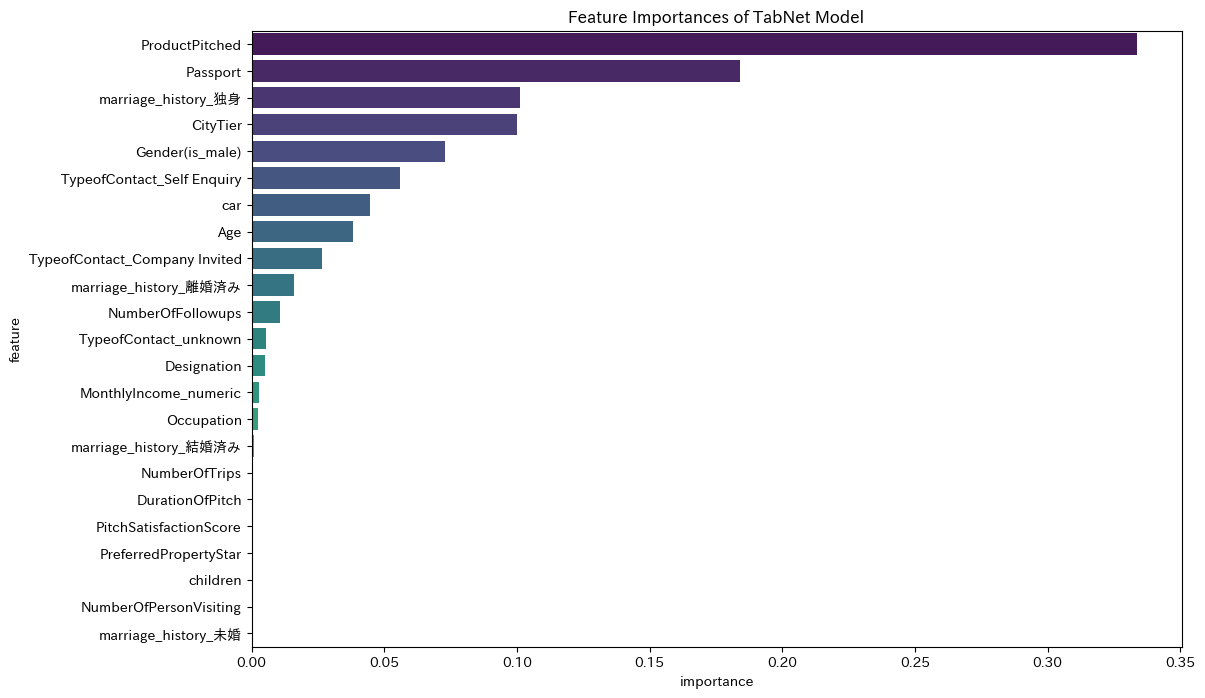

In [ ]:
feature_importances_loaded.sort_values(
    by = "importance", 
    ascending = False, 
    inplace = True
)
plt.figure(figsize = (12, 8))
sns.barplot(y = feature_importances_loaded["feature"][:25], x = feature_importances_loaded["importance"][:25], palette = "viridis")
plt.title("Feature Importances of TabNet Model")
plt.savefig(data_directory_name + "/feat_imp_tb_atac_2.png", dpi = 100)
plt.show()

In [ ]:
feature_importances = pd.DataFrame()
feature_importances["feature"] = train_df.drop(columns=[TARGET_COLUMN, "id"]).columns
feature_importances["importance"] = tabnet_model.feature_importances_

/var/folders/5_/6wgs064d6yj6tsvtkjt8g_740000gn/T/ipykernel_4433/2239368221.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25], palette = "viridis")


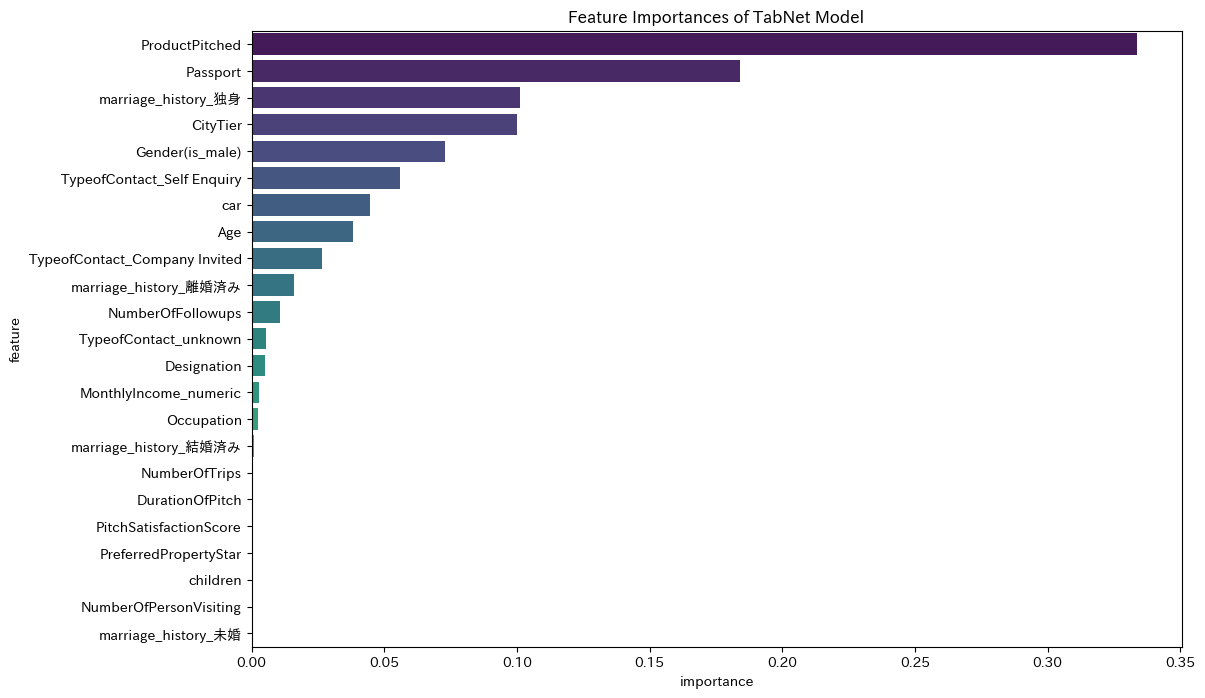

In [ ]:
feature_importances.sort_values(
    by = "importance", 
    ascending = False, 
    inplace = True
)
plt.figure(figsize = (12, 8))
sns.barplot(y = feature_importances["feature"][:25], x = feature_importances["importance"][:25], palette = "viridis")
plt.title("Feature Importances of TabNet Model")
plt.savefig(data_directory_name + "/feat_imp_tb_atac_2.png", dpi = 100)
plt.show()

In [ ]:
val_predicted_df = pd.DataFrame()
val_predicted_df["acutual"] = y_val
val_predicted_df["prediction"] = tabnet_model.predict_proba(X_val)[:, 1]

In [ ]:
# 実際のラベルと予測確率を取得
y_true = val_predicted_df["acutual"]
y_pred = val_predicted_df["prediction"]
print(y_true)
# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUCを計算
roc_auc = auc(fpr, tpr)
print(roc_auc)

0      0.0
1      0.0
2      0.0
3      1.0
4      0.0
      ... 
693    0.0
694    1.0
695    1.0
696    0.0
697    0.0
Name: acutual, Length: 698, dtype: float32
0.8612976809022937


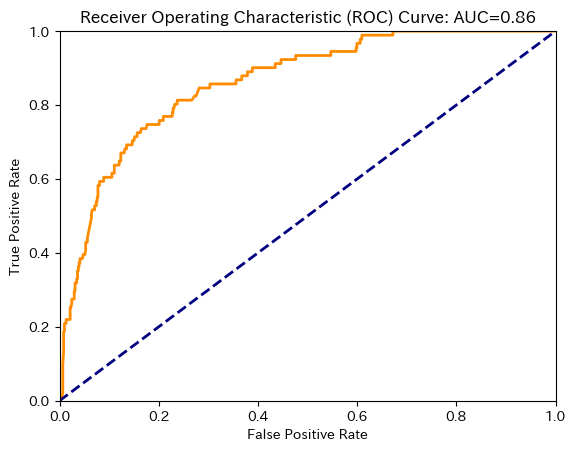

In [ ]:
# 実際のラベルと予測確率を取得
y_true = val_predicted_df["acutual"]
y_pred = val_predicted_df["prediction"]

# ROC曲線を計算
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# AUCを計算
roc_auc = auc(fpr, tpr)

# ROC曲線をプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve: AUC={0:0.2f}'.format(roc_auc))
plt.savefig(data_directory_name + "/val_roc_curve_tabnet.png", dpi = 100)


In [ ]:
# 特徴量として使用するカラムを定義 (NUMERIC_COLUMNSに基づく)
X_test = test_df.drop(columns=["id"]).values  # "id" カラムを除外して特徴量に
y_test = tabnet_model.predict_proba(X_test)[:, 1]  # 予測確率を取得

# 結果をデータフレームに変換
submission_df = pd.DataFrame({
    "id": test_df["id"].astype(int),  # "id" カラムを使用
    "prediction": y_test
})

# CSVファイルに保存
submission_df.to_csv(data_directory_name + "/submission_2.csv", index=False, header=None)